In [113]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, chi2_contingency
from statsmodels.stats.multitest import multipletests

def calculate_summary_stats(var, group1, group2):
    """
    Calculate summary statistics and perform statistical tests:
    - Mann-Whitney U for continuous variables.
    - Chi-square test for categorical variables (sex, education).
    
    Args:
        var (str): Variable name.
        group1 (pd.DataFrame): Subset of data for group 1 (e.g., young).
        group2 (pd.DataFrame): Subset of data for group 2 (e.g., old).

    Returns:
        Tuple: Summary statistics for both groups, p-value, test statistic, and direction.
    """
    if var in ["sex", "Education"]:  # Categorical variables
        contingency_table = pd.crosstab(df[var], df["group"])
        chi2_stat, p_val, _, _ = chi2_contingency(contingency_table)
        
        categories1 = group1[var].value_counts(normalize=True) * 100
        categories2 = group2[var].value_counts(normalize=True) * 100

        group1_stats = "; ".join([f"{cat}: {categories1.get(cat, 0):.1f}%" for cat in sorted(set(categories1.index).union(categories2.index))])
        group2_stats = "; ".join([f"{cat}: {categories2.get(cat, 0):.1f}%" for cat in sorted(set(categories1.index).union(categories2.index))])
        
        return group1_stats, group2_stats, p_val, chi2_stat, "NA"

    else:  # Continuous variables
        mean1, std1 = group1[var].mean(), group1[var].std()
        mean2, std2 = group2[var].mean(), group2[var].std()
        direction = "Young" if mean1 > mean2 else "Old"
        
        u_stat, p_val = mannwhitneyu(group1[var].dropna(), group2[var].dropna(), alternative='two-sided')
        return f"{mean1:.2f} ± {std1:.2f}", f"{mean2:.2f} ± {std2:.2f}", p_val, u_stat, direction

def create_table1(data, group_col, group1_label, group2_label, variables, group_labels):
    """
    Generate Table 1 with summary statistics and correct statistical tests.

    Args:
        data (pd.DataFrame): Input dataset.
        group_col (str): Column name for group classification.
        group1_label: Label for group 1 (e.g., "Young").
        group2_label: Label for group 2 (e.g., "Old").
        variables (list): List of variables to compare.
        group_labels (list): Labels for the two groups.

    Returns:
        pd.DataFrame: Summary statistics and p-values.
    """
    group1 = data[data[group_col] == group1_label]
    group2 = data[data[group_col] == group2_label]
    
    results = []
    for var in variables:
        stat1, stat2, p_val, test_stat, direction = calculate_summary_stats(var, group1, group2)
        results.append((var, stat1, stat2, p_val, test_stat, direction))
    
    results_df = pd.DataFrame(results, columns=["Variable", group_labels[0], group_labels[1], "p-value", "Test Statistic", "Direction"])
    
    # Apply FDR correction
    p_values = results_df["p-value"].values
    _, corrected_p, _, _ = multipletests(p_values, method="fdr_bh")
    results_df["Corrected p-value (FDR)"] = corrected_p
    
    return results_df

# Load your actual dataset
file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\CamCAN_data\Final_Merged_CAMCAN_aseg_lh_volume.csv"
df = pd.read_csv(file_path)

# Define groups and variables
df["group"] = np.where(df["age"] <= 45, "Young", np.where(df["age"] >= 65, "Old", "Middle"))
variables = [
    "HD1", "HD2", "HD3", "HD4", "HD5", "HD6", "HD7",  # Affective symptoms
    "HA1", "HA2", "HA3", "HA4", "HA5", "HA6", "HA7",  # Anxiety symptoms
    "Memory", "Fluency", "Language", "Visuospatial", "Orientation",  # Cognitive functions
    "sex", "Education"  # Demographic variables
]
group_labels = ["Young", "Old"]

# Create Table 1
table1 = create_table1(df, group_col="group", group1_label="Young", group2_label="Old", variables=variables, group_labels=group_labels)

# Display the table
print("Table 1: Summary Statistics and Comparisons")
print(table1.to_string(index=False))


Table 1: Summary Statistics and Comparisons
    Variable                                       Young                                          Old      p-value  Test Statistic Direction  Corrected p-value (FDR)
         HD1                                 0.46 ± 0.67                                  0.61 ± 0.78 6.324170e-06   415579.000000       Old             9.486255e-06
         HD2                                 0.26 ± 0.50                                  0.27 ± 0.54 8.969692e-01   466113.000000       Old             8.969692e-01
         HD3                                 0.35 ± 0.54                                  0.27 ± 0.52 2.315898e-04   500249.000000     Young             3.039617e-04
         HD4                                 0.70 ± 0.72                                  1.36 ± 0.93 1.249959e-57   282006.000000       Old             8.749713e-57
         HD5                                 0.50 ± 0.74                                  0.47 ± 0.71 5.217775e-01   471670.00

In [115]:
# Update create_table1 function to use scientific notation for very small p-values
def create_table1(data, group_col, group1_label, group2_label, variables, group_labels):
    """
    Create Table 1 comparing two groups with descriptive statistics and appropriate tests.

    Args:
        data (pd.DataFrame): Input dataset.
        group_col (str): Column name for group classification.
        group1_label: Label for group 1 (e.g., "Young Adults").
        group2_label: Label for group 2 (e.g., "Older Adults").
        variables (list): List of variable names to compare.
        group_labels (list): Labels for the two groups to display.

    Returns:
        pd.DataFrame: Summary statistics and corrected p-values.
    """
    group1 = data[data[group_col] == group1_label]
    group2 = data[data[group_col] == group2_label]

    results = []
    for var in variables:
        stat1, stat2, test_stat, p_val = calculate_summary_stats(var, group1, group2)
        results.append((var, stat1, stat2, test_stat, p_val))

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results, columns=["Variable", f"{group_labels[0]} (mean ± SD or %)", f"{group_labels[1]} (mean ± SD or %)", "Test Statistic", "p-value"])

    # Correct p-values for multiple comparisons
    p_values = results_df["p-value"].values
    _, corrected_p, _, _ = multipletests(p_values, method="fdr_bh")
    results_df["Corrected p-value (FDR)"] = [
        f"{p:.2e}" if p < 0.001 else round(p, 5) for p in corrected_p
    ]

    return results_df

# Print the exact p-value for Education
table1 = create_table1(df, group_col="group", group1_label="Young Adults", group2_label="Older Adults", variables=variables, group_labels=group_labels)
education_p_value = table1.loc[table1["Variable"] == "Education", "Corrected p-value (FDR)"].values[0]
print(f"P-value for Education: {education_p_value}")


P-value for Education: 1.20e-55



Analyzing Young group...
Number of participants in Young group: 756


C:\Users\LAB-Mobile\AppData\Local\Temp\ipykernel_13104\1948041193.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[covariate].fillna(data[covariate].mean(), inplace=True)


Selected Lambda (Alpha) via EBIC: 0.030539147538078473


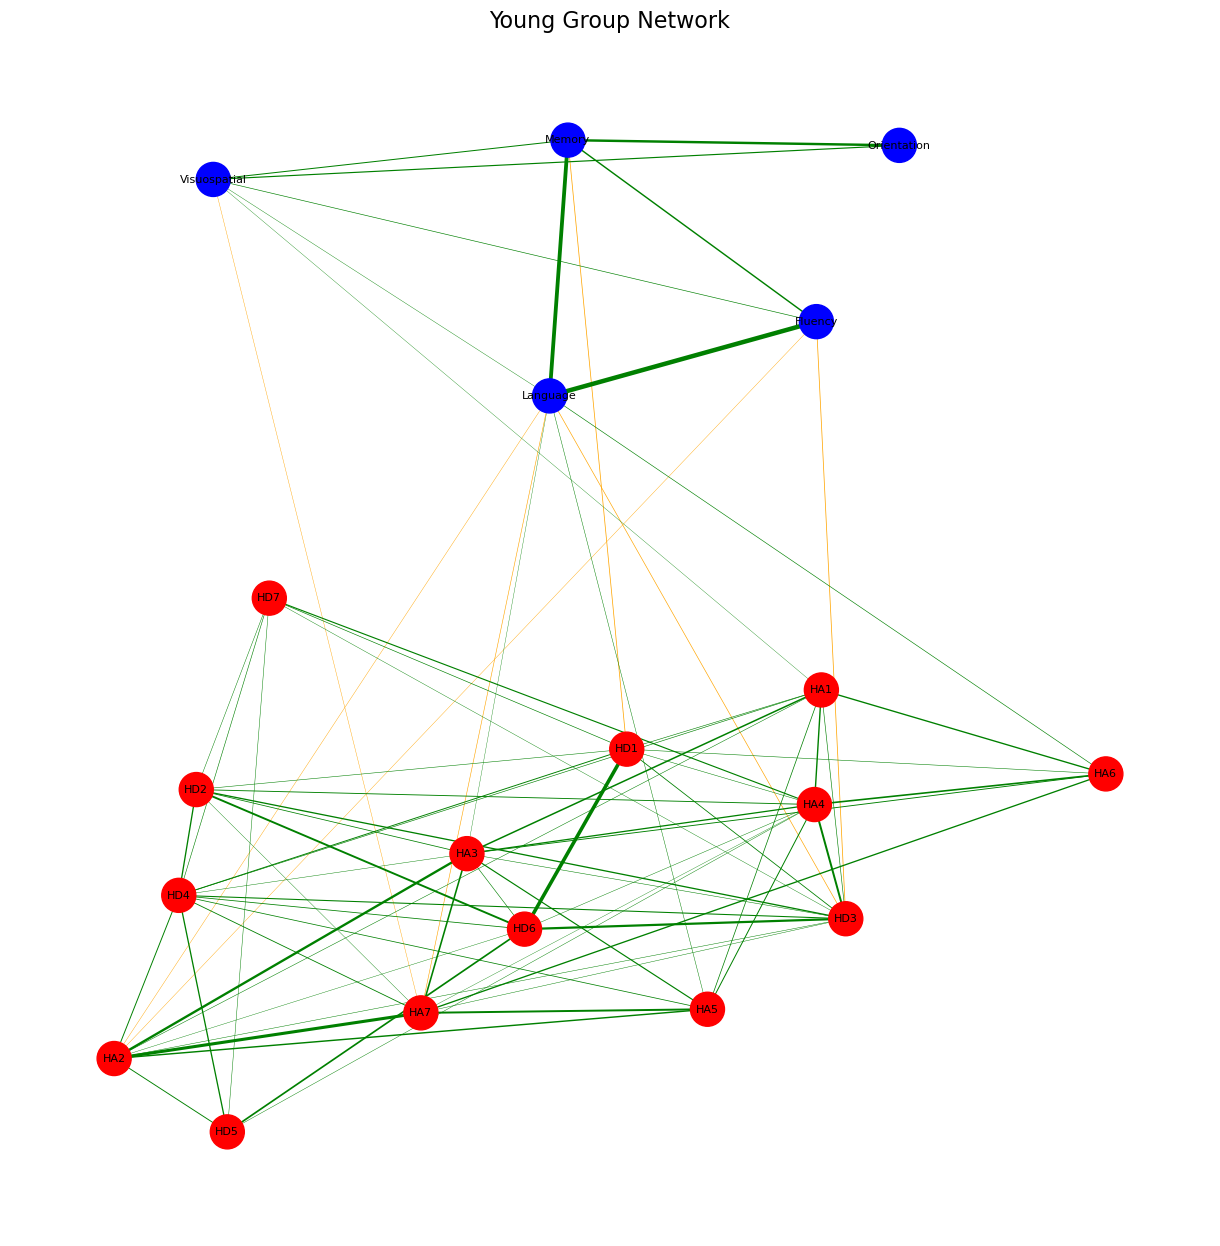

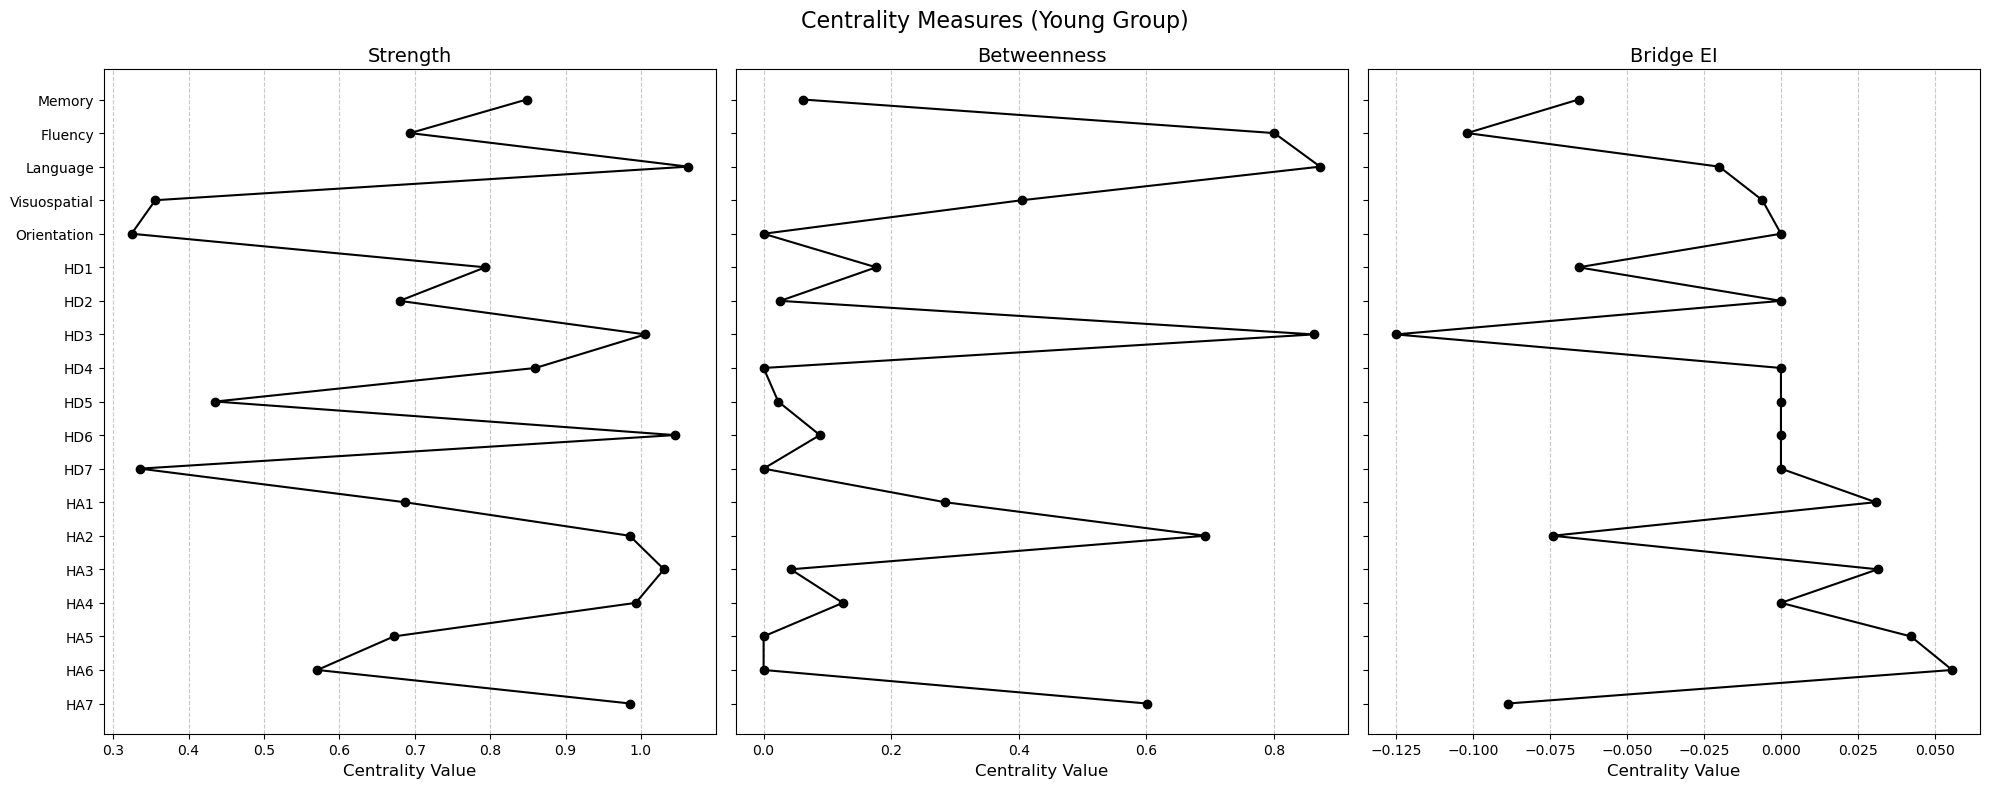


Centrality Measures for Young Group:

Strength:
Memory: 0.8483
Fluency: 0.6938
Language: 1.0625
Visuospatial: 0.3557
Orientation: 0.3242
HD1: 0.7935
HD3: 1.0059
HA2: 0.9850
HA3: 1.0305
HA5: 0.6723
HA6: 0.5707
HA7: 0.9860
HA1: 0.6865
HD2: 0.6797
HD4: 0.8600
HD6: 1.0448
HD7: 0.3354
HA4: 0.9931
HD5: 0.4352

Betweenness:
Memory: 0.0621
Fluency: 0.8007
Language: 0.8725
Visuospatial: 0.4052
Orientation: 0.0000
HD1: 0.1765
HD3: 0.8627
HA2: 0.6928
HA3: 0.0425
HA5: 0.0000
HA6: 0.0000
HA7: 0.6013
HA1: 0.2843
HD2: 0.0261
HD4: 0.0000
HD6: 0.0882
HD7: 0.0000
HA4: 0.1242
HD5: 0.0229

Bridge EI:
Memory: -0.0657
Fluency: -0.1019
Language: -0.0200
Visuospatial: -0.0060
Orientation: 0.0000
HD1: -0.0657
HD3: -0.1251
HA2: -0.0741
HA3: 0.0314
HA5: 0.0422
HA6: 0.0556
HA7: -0.0887
HA1: 0.0308
HD2: 0.0000
HD4: 0.0000
HD6: 0.0000
HD7: 0.0000
HA4: 0.0000
HD5: 0.0000

Analyzing Old group...
Number of participants in Old group: 1230


C:\Users\LAB-Mobile\AppData\Local\Temp\ipykernel_13104\1948041193.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[covariate].fillna(data[covariate].mean(), inplace=True)


Selected Lambda (Alpha) via EBIC: 0.029037185085977253


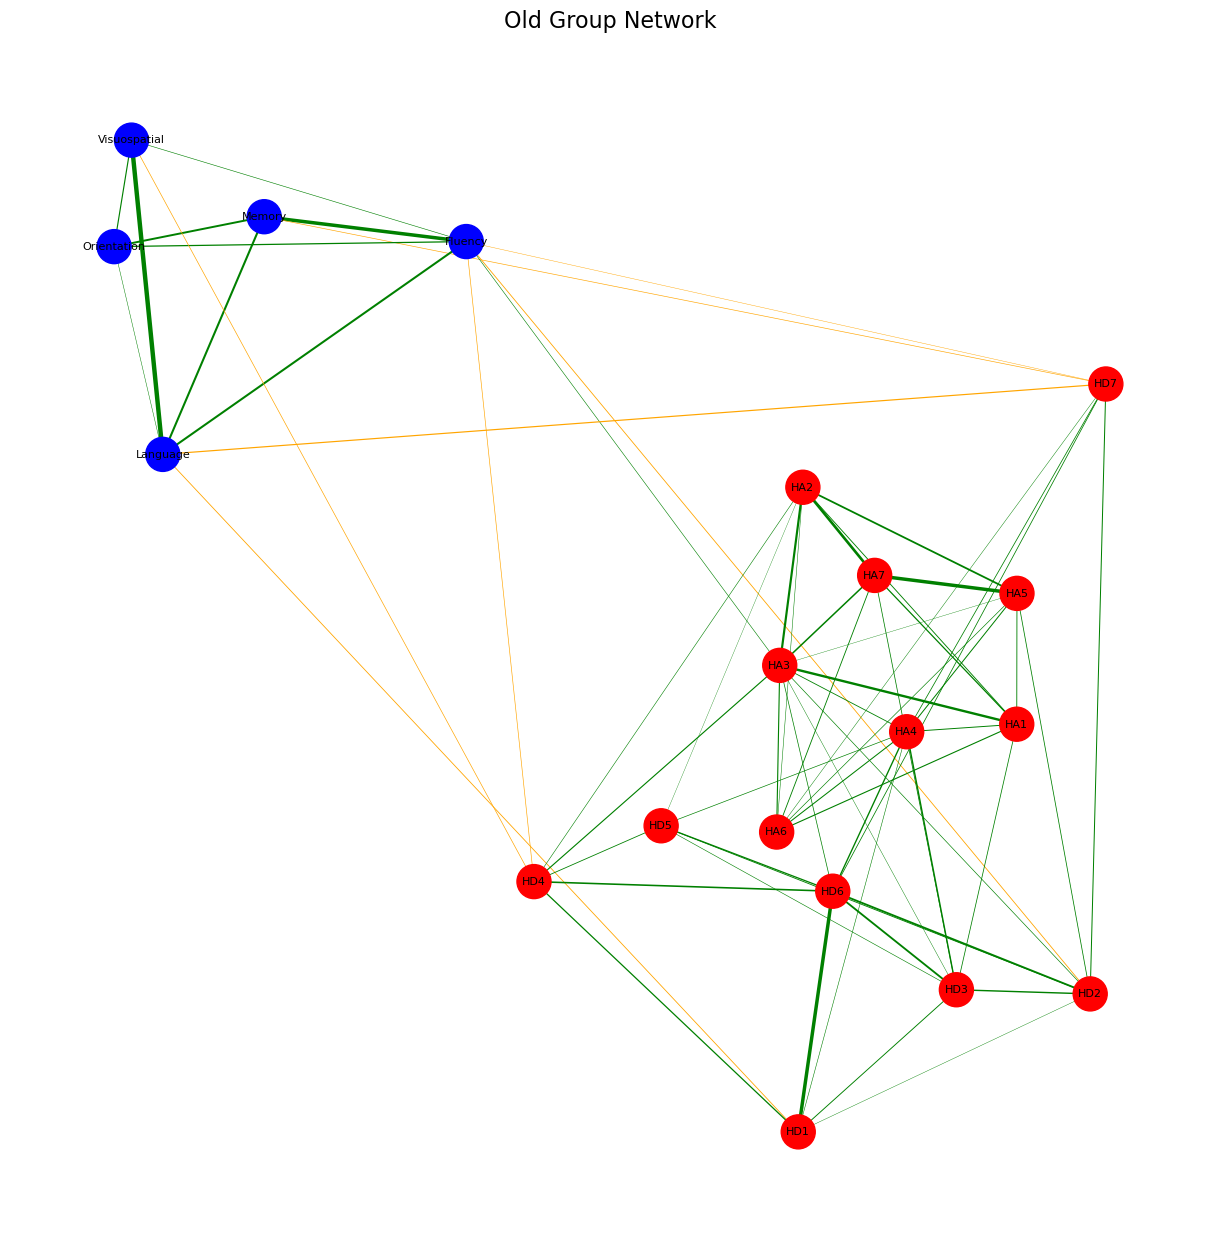

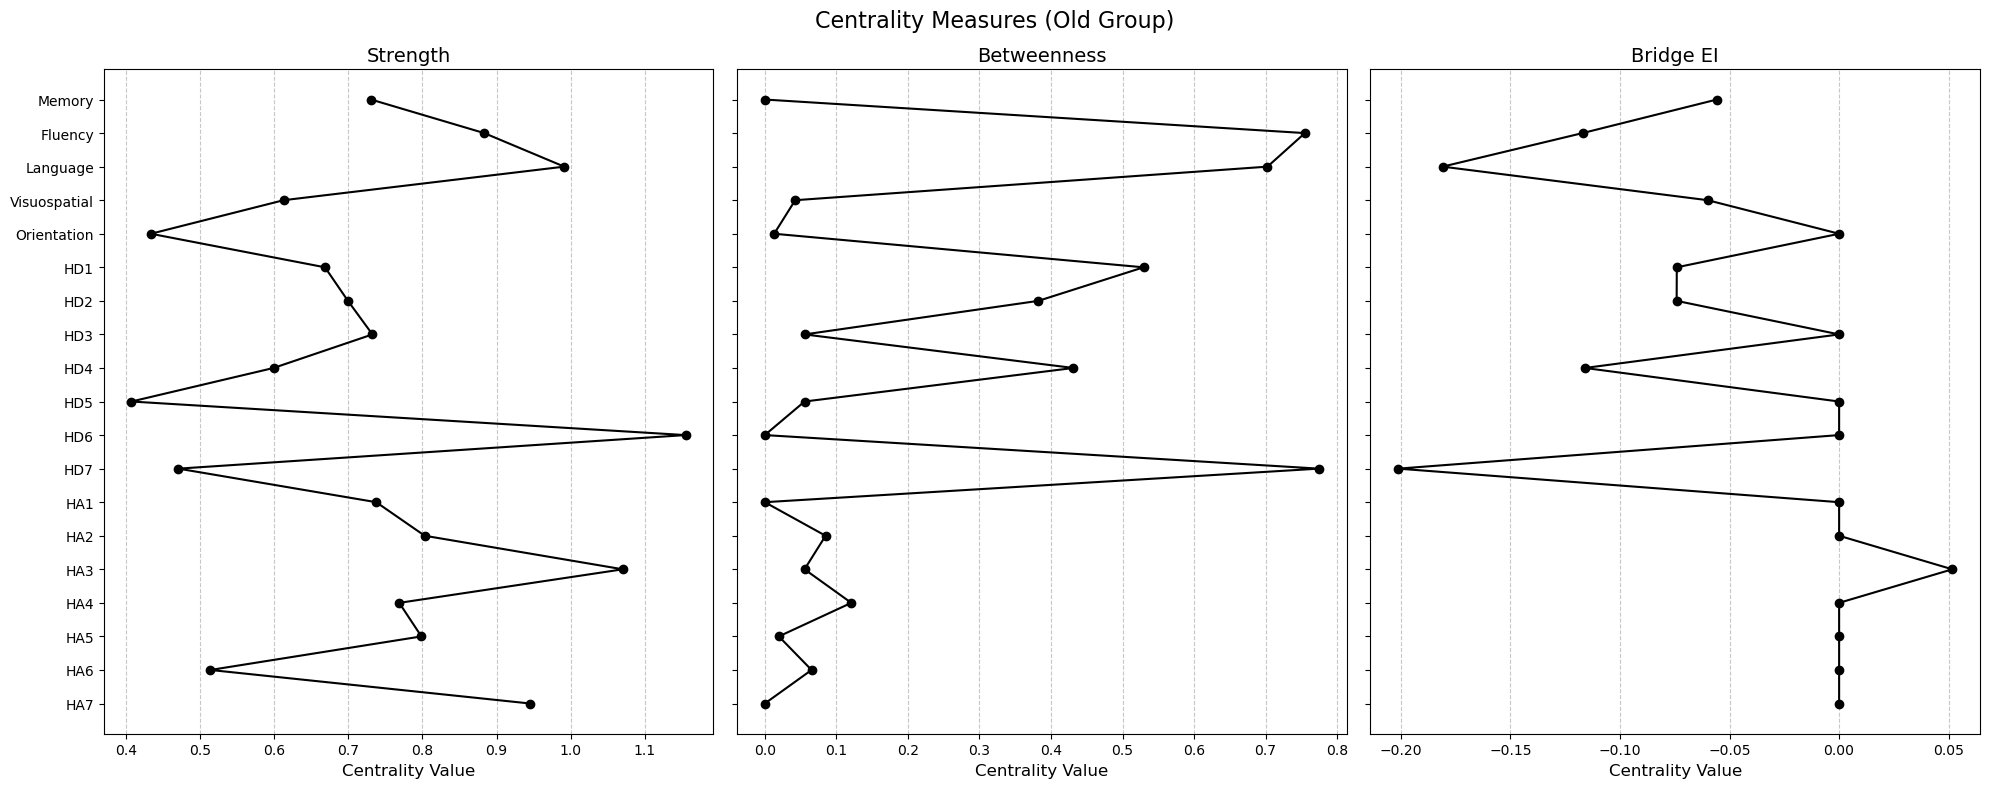


Centrality Measures for Old Group:

Strength:
Memory: 0.7307
Fluency: 0.8833
Language: 0.9912
Orientation: 0.4338
HD7: 0.4709
Visuospatial: 0.6128
HD2: 0.6995
HD4: 0.5992
HA3: 1.0703
HD1: 0.6685
HD3: 0.7325
HD6: 1.1548
HA4: 0.7687
HD5: 0.4075
HA5: 0.7986
HA1: 0.7376
HA7: 0.9454
HA2: 0.8031
HA6: 0.5140

Betweenness:
Memory: 0.0000
Fluency: 0.7549
Language: 0.7026
Orientation: 0.0131
HD7: 0.7745
Visuospatial: 0.0425
HD2: 0.3824
HD4: 0.4314
HA3: 0.0556
HD1: 0.5294
HD3: 0.0556
HD6: 0.0000
HA4: 0.1209
HD5: 0.0556
HA5: 0.0196
HA1: 0.0000
HA7: 0.0000
HA2: 0.0850
HA6: 0.0654

Bridge EI:
Memory: -0.0558
Fluency: -0.1171
Language: -0.1809
Orientation: 0.0000
HD7: -0.2012
Visuospatial: -0.0600
HD2: -0.0741
HD4: -0.1160
HA3: 0.0516
HD1: -0.0741
HD3: 0.0000
HD6: 0.0000
HA4: 0.0000
HD5: 0.0000
HA5: 0.0000
HA1: 0.0000
HA7: 0.0000
HA2: 0.0000
HA6: 0.0000


In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.covariance import GraphicalLassoCV
from sklearn.preprocessing import StandardScaler

# Preprocessing Function
def preprocess_data(data, nodes, covariates):
    data = data.dropna(subset=nodes)
    for covariate in covariates:
        if covariate in data.columns:
            data[covariate].fillna(data[covariate].mean(), inplace=True)
    scaler = StandardScaler()
    data[covariates] = scaler.fit_transform(data[covariates])
    for node in nodes:
        X = data[covariates].values
        y = data[node].values
        ridge_reg_param = 1e-5
        XtX = np.dot(X.T, X) + ridge_reg_param * np.eye(X.shape[1])
        Xty = np.dot(X.T, y)
        beta = np.linalg.solve(XtX, Xty)
        data[node] = y - np.dot(X, beta)
    return data

# Construct Partial Correlation Network with EBIC Threshold
def construct_partial_correlation_network(data, nodes):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[nodes])
    model = GraphicalLassoCV()
    model.fit(scaled_data)
    
    best_alpha = model.alpha_  # Best alpha from EBIC
    print(f"Selected Lambda (Alpha) via EBIC: {best_alpha}")
    
    precision_matrix = model.precision_
    partial_corr_matrix = -precision_matrix / np.sqrt(
        np.outer(np.diag(precision_matrix), np.diag(precision_matrix))
    )
    np.fill_diagonal(partial_corr_matrix, 0)
    
    # Apply threshold based on EBIC-selected alpha
    threshold = best_alpha
    partial_corr_matrix[np.abs(partial_corr_matrix) < threshold] = 0
    return pd.DataFrame(partial_corr_matrix, index=nodes, columns=nodes)

# Create NetworkX Graph
def create_network(corr_matrix):
    G = nx.Graph()
    for i, node1 in enumerate(corr_matrix.columns):
        for j, node2 in enumerate(corr_matrix.columns):
            weight = corr_matrix.iloc[i, j]
            if weight != 0:
                G.add_edge(node1, node2, weight=weight)
    return G

# Compute Centralities
def compute_centralities(G, cognitive_nodes, affective_nodes):
    strength = {node: sum(abs(G[u][v]['weight']) for u, v in G.edges(node)) for node in G.nodes}
    betweenness = nx.betweenness_centrality(G, weight='weight')
    bridge_expected_influence = {
        node: sum(
            G[u][v]['weight'] for u, v in G.edges(node)
            if (node in cognitive_nodes and v in affective_nodes) or (node in affective_nodes and v in cognitive_nodes)
        )
        for node in G.nodes
    }
    return strength, betweenness, bridge_expected_influence

def visualize_centralities_line(centrality_data, nodes, title):
    fig, axs = plt.subplots(1, 3, figsize=(20, 8), sharey=True)
    centrality_names = ["Strength", "Betweenness", "Bridge EI"]

    for i, centrality_name in enumerate(centrality_names):
        centrality_values = centrality_data[centrality_name]
        values = [centrality_values.get(node, 0) for node in nodes]
        
        axs[i].plot(values, range(len(nodes)), marker='o', color='black', linestyle='-', linewidth=1.5)
        axs[i].set_yticks(range(len(nodes)))
        axs[i].set_yticklabels(nodes, fontsize=10)
        axs[i].set_title(centrality_name, fontsize=14)
        axs[i].invert_yaxis()
        axs[i].set_xlabel("Centrality Value", fontsize=12)
        axs[i].grid(axis='x', linestyle='--', alpha=0.7)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualization for Network
def visualize_network(G, title, cognitive_nodes, affective_nodes):
    scale_factor = 2
    pos = nx.spring_layout(G, seed=42, k=scale_factor / np.sqrt(len(G.nodes)))
    plt.figure(figsize=(12, 12))
    node_colors = ["blue" if node in cognitive_nodes else "red" for node in G.nodes]
    edge_colors = ['green' if G[u][v]['weight'] > 0 else 'orange' for u, v in G.edges()]
    edge_weights = [abs(G[u][v]['weight']) * 8 for u, v in G.edges()]
    nx.draw(
        G, pos, with_labels=True, node_color=node_colors, node_size=600,
        edge_color=edge_colors, width=edge_weights, font_size=8
    )
    plt.title(title, fontsize=16)
    plt.show()

# Main Analysis
file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\CamCAN_data\Final_Merged_CAMCAN_aseg_lh_volume.csv"
df = pd.read_csv(file_path)

cognitive_nodes = ['Memory', 'Fluency', 'Language', 'Visuospatial', 'Orientation']
affective_nodes = ['HD1', 'HD2', 'HD3', 'HD4', 'HD5', 'HD6', 'HD7', 'HA1', 'HA2', 'HA3', 'HA4', 'HA5', 'HA6', 'HA7']
nodes = cognitive_nodes + affective_nodes
covariates = ['sex', 'Education']

df_young = df[df['age'] <= 45].copy()
df_old = df[df['age'] >= 65].copy()

results = {}
for group, data in zip(["Young", "Old"], [df_young, df_old]):
    print(f"\nAnalyzing {group} group...")
    data = preprocess_data(data, nodes, covariates)
    print(f"Number of participants in {group} group: {data.shape[0]}")

    partial_corr = construct_partial_correlation_network(data, nodes)
    G = create_network(partial_corr)

    visualize_network(G, f"{group} Group Network", cognitive_nodes, affective_nodes)

    strength, betweenness, bridge_expected_influence = compute_centralities(
        G, cognitive_nodes, affective_nodes
    )

    centrality_data = {
        "Strength": strength,
        "Betweenness": betweenness,
        "Bridge EI": bridge_expected_influence
    }
    results[group] = centrality_data
    visualize_centralities_line(centrality_data, nodes, f"Centrality Measures ({group} Group)")

    print(f"\nCentrality Measures for {group} Group:")
    for metric, values in centrality_data.items():
        print(f"\n{metric}:")
        for node, value in values.items():
            print(f"{node}: {value:.4f}")



Analyzing Young group...
Number of participants in Young group: 756


C:\Users\LAB-Mobile\AppData\Local\Temp\ipykernel_13104\1516758985.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[covariate].fillna(data[covariate].mean(), inplace=True)


Selected Lambda (Alpha) via EBIC: 0.030539147538078473

Analyzing Old group...
Number of participants in Old group: 1230


C:\Users\LAB-Mobile\AppData\Local\Temp\ipykernel_13104\1516758985.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[covariate].fillna(data[covariate].mean(), inplace=True)


Selected Lambda (Alpha) via EBIC: 0.029037185085977253


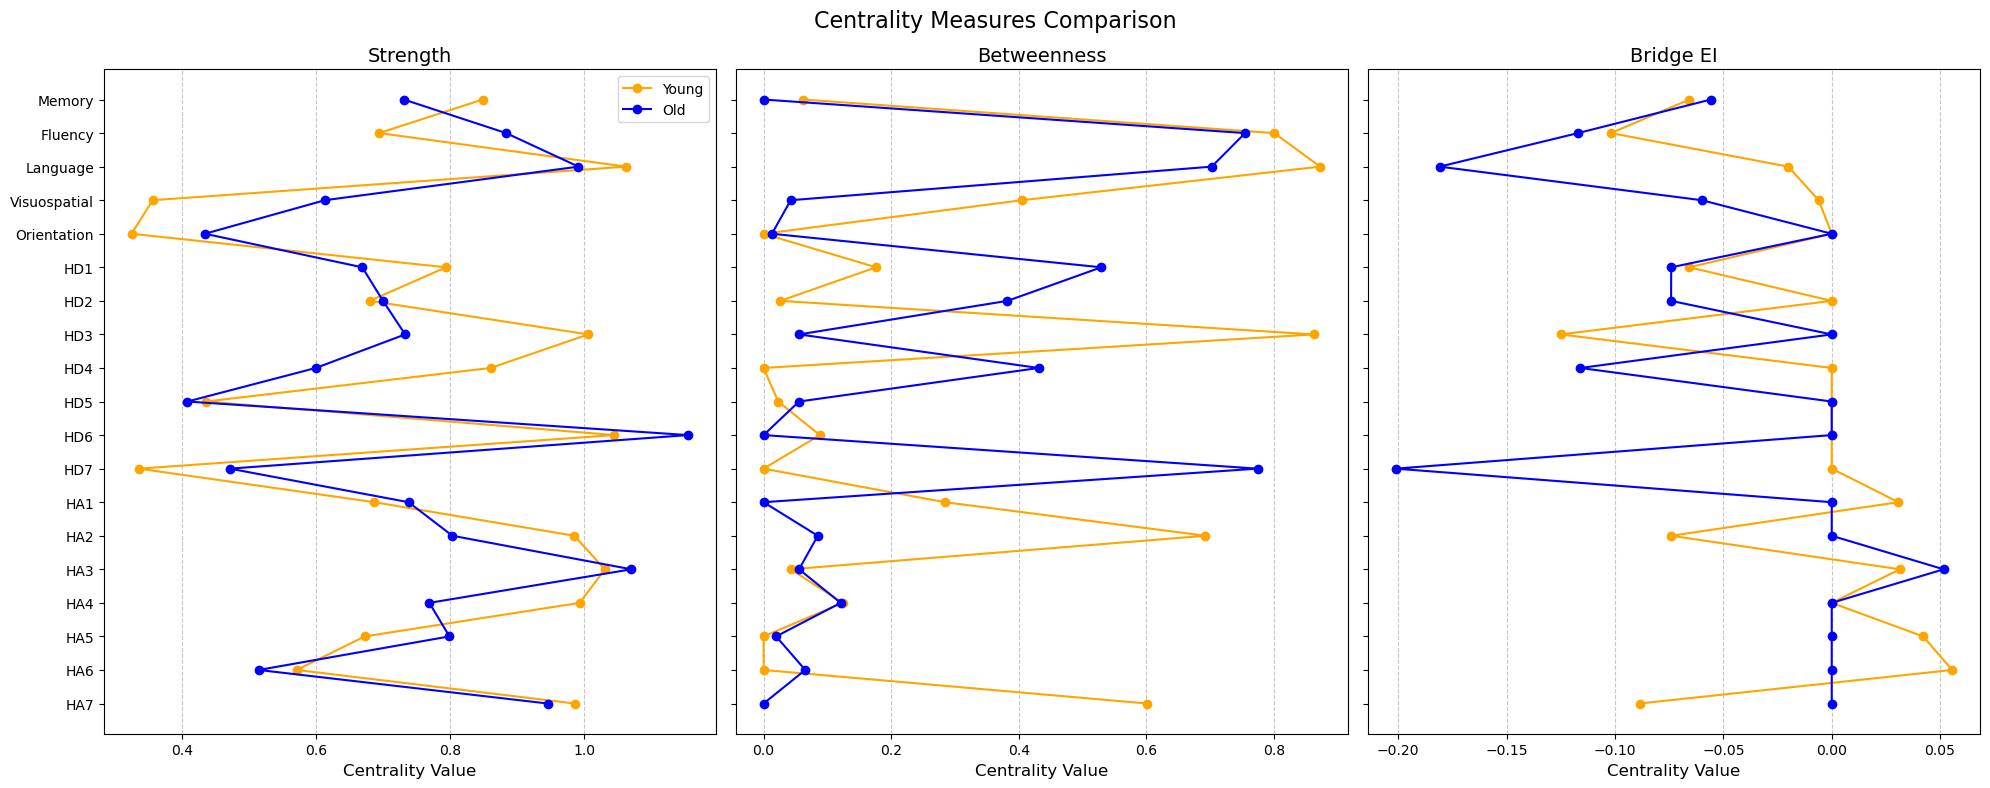


Spearman Correlation Between Young and Old:
Strength: Spearman Rho = 0.7947, P-Value = 0.0000
Betweenness: Spearman Rho = 0.0454, P-Value = 0.8535
Bridge EI: Spearman Rho = 0.3260, P-Value = 0.1732


In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.covariance import GraphicalLassoCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr

# Preprocessing Function
def preprocess_data(data, nodes, covariates):
    data = data.dropna(subset=nodes)
    for covariate in covariates:
        if covariate in data.columns:
            data[covariate].fillna(data[covariate].mean(), inplace=True)
    scaler = StandardScaler()
    data[covariates] = scaler.fit_transform(data[covariates])
    for node in nodes:
        X = data[covariates].values
        y = data[node].values
        ridge_reg_param = 1e-5
        XtX = np.dot(X.T, X) + ridge_reg_param * np.eye(X.shape[1])
        Xty = np.dot(X.T, y)
        beta = np.linalg.solve(XtX, Xty)
        data[node] = y - np.dot(X, beta)
    return data

# Construct Partial Correlation Network with EBIC Threshold
def construct_partial_correlation_network(data, nodes):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[nodes])
    model = GraphicalLassoCV()
    model.fit(scaled_data)
    
    best_alpha = model.alpha_  # Best alpha from EBIC
    print(f"Selected Lambda (Alpha) via EBIC: {best_alpha}")
    
    precision_matrix = model.precision_
    partial_corr_matrix = -precision_matrix / np.sqrt(
        np.outer(np.diag(precision_matrix), np.diag(precision_matrix))
    )
    np.fill_diagonal(partial_corr_matrix, 0)
    
    # Apply threshold based on EBIC-selected alpha
    threshold = best_alpha
    partial_corr_matrix[np.abs(partial_corr_matrix) < threshold] = 0
    return pd.DataFrame(partial_corr_matrix, index=nodes, columns=nodes)

# Create NetworkX Graph
def create_network(corr_matrix):
    G = nx.Graph()
    for i, node1 in enumerate(corr_matrix.columns):
        for j, node2 in enumerate(corr_matrix.columns):
            weight = corr_matrix.iloc[i, j]
            if weight != 0:
                G.add_edge(node1, node2, weight=weight)
    return G

# Compute Centralities
def compute_centralities(G, cognitive_nodes, affective_nodes):
    strength = {node: sum(abs(G[u][v]['weight']) for u, v in G.edges(node)) for node in G.nodes}
    betweenness = nx.betweenness_centrality(G, weight='weight')
    bridge_expected_influence = {
        node: sum(
            G[u][v]['weight'] for u, v in G.edges(node)
            if (node in cognitive_nodes and v in affective_nodes) or (node in affective_nodes and v in cognitive_nodes)
        )
        for node in G.nodes
    }
    return strength, betweenness, bridge_expected_influence

# Visualization for Centrality Measures Comparison
def visualize_centralities_comparison(centrality_data_young, centrality_data_old, nodes, title):
    fig, axs = plt.subplots(1, 3, figsize=(20, 8), sharey=True)
    centrality_names = ["Strength", "Betweenness", "Bridge EI"]
    colors = {'Young': 'orange', 'Old': 'blue'}

    for i, centrality_name in enumerate(centrality_names):
        young_values = [centrality_data_young[centrality_name].get(node, 0) for node in nodes]
        old_values = [centrality_data_old[centrality_name].get(node, 0) for node in nodes]

        axs[i].plot(young_values, range(len(nodes)), marker='o', color=colors['Young'], linestyle='-', label='Young')
        axs[i].plot(old_values, range(len(nodes)), marker='o', color=colors['Old'], linestyle='-', label='Old')

        axs[i].set_yticks(range(len(nodes)))
        axs[i].set_yticklabels(nodes, fontsize=10)
        axs[i].set_title(centrality_name, fontsize=14)
        axs[i].invert_yaxis()
        axs[i].set_xlabel("Centrality Value", fontsize=12)
        axs[i].grid(axis='x', linestyle='--', alpha=0.7)
        if i == 0:
            axs[i].legend(loc='best', fontsize=10)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Compute Spearman Correlation Between Young and Old
def compute_spearman_correlations(centrality_data_young, centrality_data_old, nodes):
    correlations = {}
    for centrality_name in ["Strength", "Betweenness", "Bridge EI"]:
        young_values = [centrality_data_young[centrality_name].get(node, 0) for node in nodes]
        old_values = [centrality_data_old[centrality_name].get(node, 0) for node in nodes]

        rho, p_value = spearmanr(young_values, old_values)
        correlations[centrality_name] = {
            "Spearman Rho": rho,
            "P-Value": p_value
        }
    return correlations

# Main Analysis
file_path = r"C:\\Users\\LAB-Mobile\\Documents\\Daniel\\Research\\CamCAN_data\\Final_Merged_CAMCAN_aseg_lh_volume.csv"
df = pd.read_csv(file_path)

cognitive_nodes = ['Memory', 'Fluency', 'Language', 'Visuospatial', 'Orientation']
affective_nodes = ['HD1', 'HD2', 'HD3', 'HD4', 'HD5', 'HD6', 'HD7', 'HA1', 'HA2', 'HA3', 'HA4', 'HA5', 'HA6', 'HA7']
nodes = cognitive_nodes + affective_nodes
covariates = ['sex', 'Education']

df_young = df[df['age'] <= 45].copy()
df_old = df[df['age'] >= 65].copy()

results = {}
centrality_data = {}
for group, data in zip(["Young", "Old"], [df_young, df_old]):
    print(f"\nAnalyzing {group} group...")
    data = preprocess_data(data, nodes, covariates)
    print(f"Number of participants in {group} group: {data.shape[0]}")

    partial_corr = construct_partial_correlation_network(data, nodes)
    G = create_network(partial_corr)

    strength, betweenness, bridge_expected_influence = compute_centralities(
        G, cognitive_nodes, affective_nodes
    )

    centrality_data[group] = {
        "Strength": strength,
        "Betweenness": betweenness,
        "Bridge EI": bridge_expected_influence
    }

# Visualization of Centrality Comparison
visualize_centralities_comparison(
    centrality_data_young=centrality_data["Young"],
    centrality_data_old=centrality_data["Old"],
    nodes=nodes,
    title="Centrality Measures Comparison"
)

# Compute and Print Spearman Correlations
spearman_correlations = compute_spearman_correlations(
    centrality_data_young=centrality_data["Young"],
    centrality_data_old=centrality_data["Old"],
    nodes=nodes
)

print("\nSpearman Correlation Between Young and Old:")
for centrality_name, values in spearman_correlations.items():
    print(f"{centrality_name}: Spearman Rho = {values['Spearman Rho']:.4f}, P-Value = {values['P-Value']:.4f}")



Analyzing Young group...
Number of participants in Young group: 756


C:\Users\LAB-Mobile\AppData\Local\Temp\ipykernel_13104\740857328.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[covariate].fillna(data[covariate].mean(), inplace=True)



Analyzing Old group...
Number of participants in Old group: 1230


C:\Users\LAB-Mobile\AppData\Local\Temp\ipykernel_13104\740857328.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[covariate].fillna(data[covariate].mean(), inplace=True)


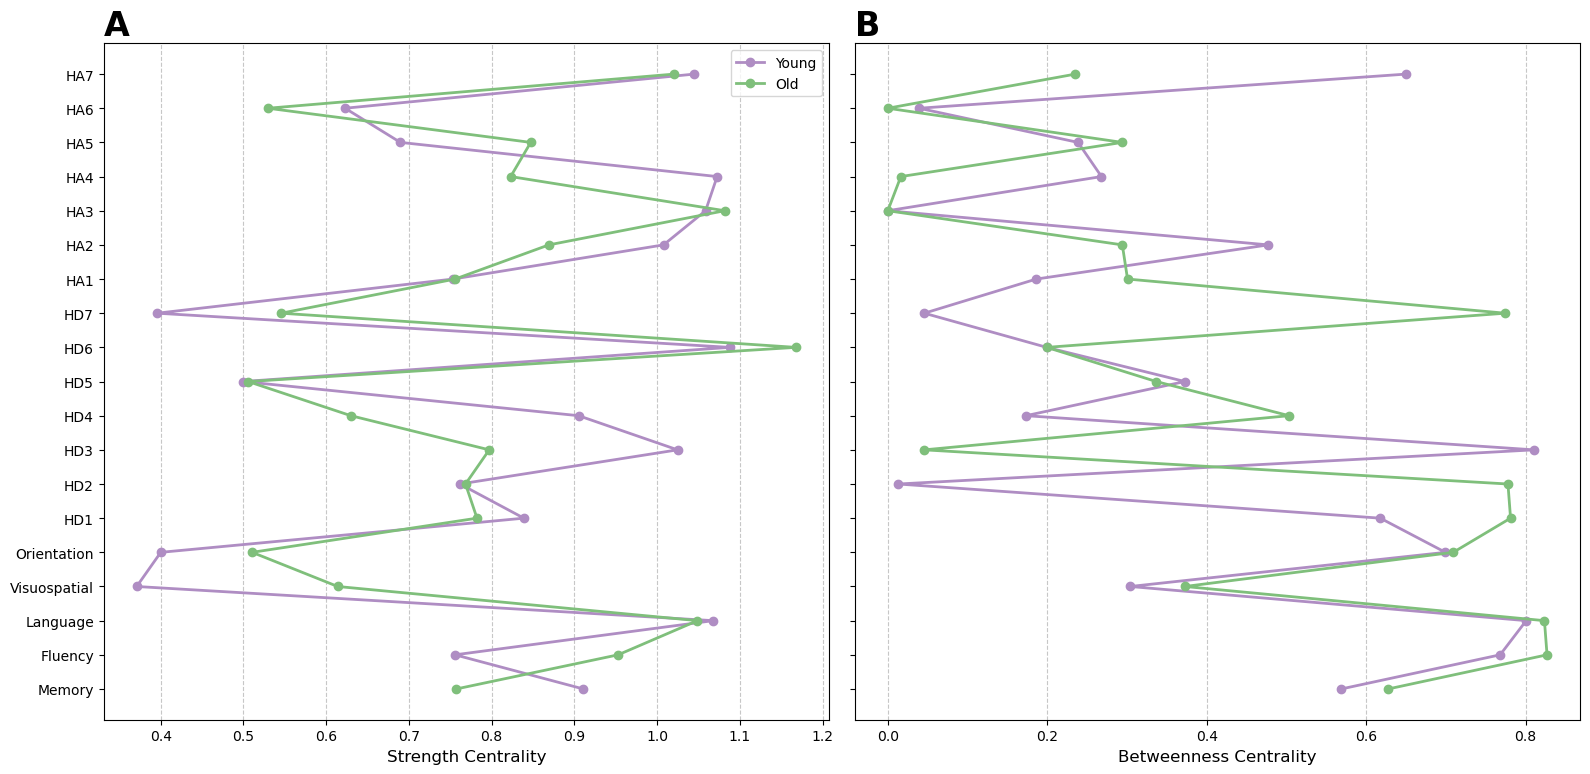

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.covariance import GraphicalLassoCV
from sklearn.preprocessing import StandardScaler

# Preprocessing Function
def preprocess_data(data, nodes, covariates):
    data = data.dropna(subset=nodes)
    for covariate in covariates:
        if covariate in data.columns:
            data[covariate].fillna(data[covariate].mean(), inplace=True)
    scaler = StandardScaler()
    data[covariates] = scaler.fit_transform(data[covariates])
    for node in nodes:
        X = data[covariates].values
        y = data[node].values
        ridge_reg_param = 1e-5
        XtX = np.dot(X.T, X) + ridge_reg_param * np.eye(X.shape[1])
        Xty = np.dot(X.T, y)
        beta = np.linalg.solve(XtX, Xty)
        data[node] = y - np.dot(X, beta)
    return data

# Construct Partial Correlation Network
def construct_partial_correlation_network(data, nodes):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[nodes])
    model = GraphicalLassoCV()
    model.fit(scaled_data)
    precision_matrix = model.precision_
    partial_corr_matrix = -precision_matrix / np.sqrt(
        np.outer(np.diag(precision_matrix), np.diag(precision_matrix))
    )
    np.fill_diagonal(partial_corr_matrix, 0)
    return pd.DataFrame(partial_corr_matrix, index=nodes, columns=nodes)

# Create NetworkX Graph
def create_network(corr_matrix):
    G = nx.Graph()
    for i, node1 in enumerate(corr_matrix.columns):
        for j, node2 in enumerate(corr_matrix.columns):
            weight = corr_matrix.iloc[i, j]
            if weight != 0:
                G.add_edge(node1, node2, weight=weight)
    return G

# Compute Centralities (Strength and Betweenness)
def compute_centralities(G):
    strength = {node: sum(abs(G[u][v]['weight']) for u, v in G.edges(node)) for node in G.nodes}
    betweenness = nx.betweenness_centrality(G, weight='weight')
    return strength, betweenness

def visualize_centralities_comparison(centrality_data_young, centrality_data_old, nodes, title):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
    centrality_names = ["Strength", "Betweenness"]
    colors = {'Young': '#af8dc3', 'Old': '#7fbf7b'} # צבעים חדשים - סגול וירוק

    for i, centrality_name in enumerate(centrality_names):
        young_values = [centrality_data_young[centrality_name].get(node, 0) for node in nodes]
        old_values = [centrality_data_old[centrality_name].get(node, 0) for node in nodes]

        axs[i].plot(young_values, range(len(nodes)), marker='o', color=colors['Young'], linewidth=2, linestyle='-', label='Young')
        axs[i].plot(old_values, range(len(nodes)), marker='o', color=colors['Old'], linewidth=2, linestyle='-', label='Old')

        axs[i].set_yticks(range(len(nodes)))
        axs[i].set_yticklabels(nodes, fontsize=10)
        axs[i].set_title(f"{chr(ord('A') + i)}", loc='left', fontsize=24, fontweight='bold')
        axs[i].invert_yaxis()
        axs[i].set_xlabel(f"{centrality_name} Centrality", fontsize=12)
        axs[i].grid(axis='x', linestyle='--', alpha=0.7)
        if i == 0:
            axs[i].legend(loc='best', fontsize=10)


    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Main Analysis
file_path = r"C:\\Users\\LAB-Mobile\\Documents\\Daniel\\Research\\CamCAN_data\\Final_Merged_CAMCAN_aseg_lh_volume.csv"
df = pd.read_csv(file_path)

cognitive_nodes = ['Memory', 'Fluency', 'Language', 'Visuospatial', 'Orientation']
affective_nodes = ['HD1', 'HD2', 'HD3', 'HD4', 'HD5', 'HD6', 'HD7', 'HA1', 'HA2', 'HA3', 'HA4', 'HA5', 'HA6', 'HA7']
nodes = cognitive_nodes + affective_nodes
covariates = ['sex', 'Education']

df_young = df[df['age'] <= 45].copy()
df_old = df[df['age'] >= 65].copy()

centrality_data = {}
for group, data in zip(["Young", "Old"], [df_young, df_old]):
    print(f"\nAnalyzing {group} group...")
    data = preprocess_data(data, nodes, covariates)
    print(f"Number of participants in {group} group: {data.shape[0]}")

    partial_corr = construct_partial_correlation_network(data, nodes)
    G = create_network(partial_corr)

    strength, betweenness = compute_centralities(G)  # Get betweenness

    centrality_data[group] = {
        "Strength": strength,
        "Betweenness": betweenness,  # Store betweenness
    }

# Visualization of Centrality Comparison
visualize_centralities_comparison(
    centrality_data_young=centrality_data["Young"],
    centrality_data_old=centrality_data["Old"],
    nodes=nodes,
    title=""
)


Analyzing Young group...
Number of participants in Young group: 756


C:\Users\LAB-Mobile\AppData\Local\Temp\ipykernel_13104\1402724230.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[covariate].fillna(data[covariate].mean(), inplace=True)



Analyzing Old group...
Number of participants in Old group: 1230


C:\Users\LAB-Mobile\AppData\Local\Temp\ipykernel_13104\1402724230.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[covariate].fillna(data[covariate].mean(), inplace=True)


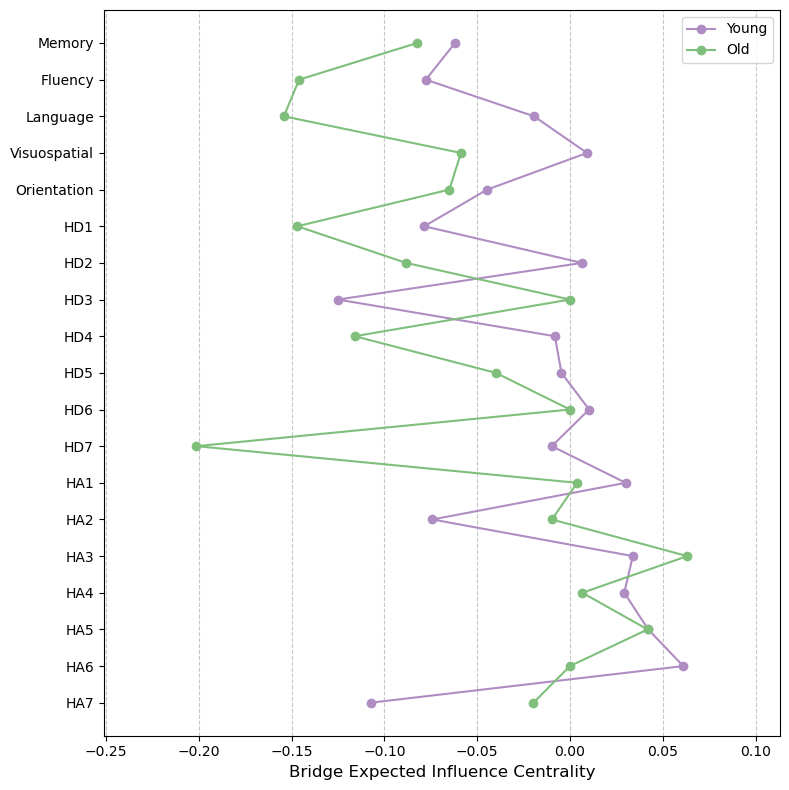

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.covariance import GraphicalLassoCV
from sklearn.preprocessing import StandardScaler

# Preprocessing Function
def preprocess_data(data, nodes, covariates):
    data = data.dropna(subset=nodes)
    for covariate in covariates:
        if covariate in data.columns:
            data[covariate].fillna(data[covariate].mean(), inplace=True)
    scaler = StandardScaler()
    data[covariates] = scaler.fit_transform(data[covariates])
    for node in nodes:
        X = data[covariates].values
        y = data[node].values
        ridge_reg_param = 1e-5
        XtX = np.dot(X.T, X) + ridge_reg_param * np.eye(X.shape[1])
        Xty = np.dot(X.T, y)
        beta = np.linalg.solve(XtX, Xty)
        data[node] = y - np.dot(X, beta)
    return data

# Construct Partial Correlation Network
def construct_partial_correlation_network(data, nodes):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[nodes])
    model = GraphicalLassoCV()
    model.fit(scaled_data)
    precision_matrix = model.precision_
    partial_corr_matrix = -precision_matrix / np.sqrt(
        np.outer(np.diag(precision_matrix), np.diag(precision_matrix))
    )
    np.fill_diagonal(partial_corr_matrix, 0)
    return pd.DataFrame(partial_corr_matrix, index=nodes, columns=nodes)

# Create NetworkX Graph
def create_network(corr_matrix):
    G = nx.Graph()
    for i, node1 in enumerate(corr_matrix.columns):
        for j, node2 in enumerate(corr_matrix.columns):
            weight = corr_matrix.iloc[i, j]
            if weight != 0:
                G.add_edge(node1, node2, weight=weight)
    return G

# Compute Centralities (Bridge EI)
def compute_centralities(G, cognitive_nodes, affective_nodes):
    bridge_expected_influence = {
        node: sum(
            G[u][v]['weight'] for u, v in G.edges(node)
            if (node in cognitive_nodes and v in affective_nodes) or (node in affective_nodes and v in cognitive_nodes)
        )
        for node in G.nodes
    }
    return bridge_expected_influence

# Visualization for Centrality Measures Comparison (modified)
def visualize_centralities_comparison(centrality_data_young, centrality_data_old, nodes):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))  # Only one subplot for BEI
    centrality_name = "Bridge Expected Influence"  # Only BEI
    colors = {'Young': '#af8dc3', 'Old': '#7fbf7b'}

    young_values = [centrality_data_young[centrality_name].get(node, 0) for node in nodes]
    old_values = [centrality_data_old[centrality_name].get(node, 0) for node in nodes]

    ax.plot(young_values, range(len(nodes)), marker='o', color=colors['Young'], linestyle='-', label='Young')
    ax.plot(old_values, range(len(nodes)), marker='o', color=colors['Old'], linestyle='-', label='Old')

    ax.set_yticks(range(len(nodes)))
    ax.set_yticklabels(nodes, fontsize=10)
    #ax.set_title(f"({chr(ord('A') + i)})", loc='left', fontsize=14) # No title
    ax.invert_yaxis()
    ax.set_xlabel(f"{centrality_name} Centrality", fontsize=12)
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    ax.legend(loc='best', fontsize=10)

    # Dynamic scaling for BEI
    min_bei = min(min(centrality_data_young["Bridge Expected Influence"].values()), min(centrality_data_old["Bridge Expected Influence"].values()))
    max_bei = max(max(centrality_data_young["Bridge Expected Influence"].values()), max(centrality_data_old["Bridge Expected Influence"].values()))
    ax.set_xlim(min_bei - 0.05, max_bei + 0.05)  # Dynamic scale for Bridge EI with a small buffer

    plt.tight_layout()
    plt.show()

# Main Analysis (modified)
file_path = r"C:\\Users\\LAB-Mobile\\Documents\\Daniel\\Research\\CamCAN_data\\Final_Merged_CAMCAN_aseg_lh_volume.csv"
df = pd.read_csv(file_path)

cognitive_nodes = ['Memory', 'Fluency', 'Language', 'Visuospatial', 'Orientation']
affective_nodes = ['HD1', 'HD2', 'HD3', 'HD4', 'HD5', 'HD6', 'HD7', 'HA1', 'HA2', 'HA3', 'HA4', 'HA5', 'HA6', 'HA7']
nodes = cognitive_nodes + affective_nodes
covariates = ['sex', 'Education']

df_young = df[df['age'] <= 45].copy()
df_old = df[df['age'] >= 65].copy()

centrality_data = {}
for group, data in zip(["Young", "Old"], [df_young, df_old]):
    print(f"\nAnalyzing {group} group...")
    data = preprocess_data(data, nodes, covariates)
    print(f"Number of participants in {group} group: {data.shape[0]}")

    partial_corr = construct_partial_correlation_network(data, nodes)
    G = create_network(partial_corr)

    bridge_expected_influence = compute_centralities(G, cognitive_nodes, affective_nodes) # Only BEI

    centrality_data[group] = {
        "Bridge Expected Influence": bridge_expected_influence, # Only BEI
    }

# Visualization of Centrality Comparison (modified)
visualize_centralities_comparison(
    centrality_data_young=centrality_data["Young"],
    centrality_data_old=centrality_data["Old"],
    nodes=nodes,
)

In [352]:
# Permutation Testing for Centrality Measures
def permutation_test_all_centralities(centrality_data, group, depression_nodes, anxiety_nodes, n_permutations=5000):
    """
    Perform permutation tests for all centrality measures between depression and anxiety nodes.

    Args:
        centrality_data (dict): Centrality data for each group.
        group (str): Group label ('Young' or 'Old').
        depression_nodes (list): List of depression-related nodes.
        anxiety_nodes (list): List of anxiety-related nodes.
        n_permutations (int): Number of permutations.

    Returns:
        dict: Results for each centrality measure.
    """
    centrality_measures = ["Strength", "Betweenness", "Bridge EI"]
    results = {}

    for measure in centrality_measures:
        # Collect centrality values
        depression_values = [
            centrality_data[group][measure].get(node, 0) for node in depression_nodes
        ]
        anxiety_values = [
            centrality_data[group][measure].get(node, 0) for node in anxiety_nodes
        ]

        # Combine and shuffle for permutation
        combined = np.array(depression_values + anxiety_values)
        observed_diff = np.mean(depression_values) - np.mean(anxiety_values)
        perm_diffs = []

        for _ in range(n_permutations):
            np.random.shuffle(combined)
            perm_depression = combined[:len(depression_values)]
            perm_anxiety = combined[len(depression_values):]
            perm_diffs.append(np.mean(perm_depression) - np.mean(perm_anxiety))

        # Calculate p-value (two-tailed)
        p_value = (np.sum(np.abs(perm_diffs) >= np.abs(observed_diff)) + 1) / (n_permutations + 1)

        results[measure] = {
            "Observed Difference": observed_diff,
            "P-Value": p_value
        }

        print(f"\n{group} - {measure} Depression vs Anxiety - Permutation Test:")
        print(f"Observed Difference = {observed_diff:.4f}, P-Value = {p_value:.4f}")

    return results

# Perform Permutation Tests for All Centralities
for group in ["Young", "Old"]:
    print(f"\nPermutation Tests for {group} group:")
    permutation_results_all_centralities = permutation_test_all_centralities(
        centrality_data=centrality_data,
        group=group,
        depression_nodes=depression_nodes,
        anxiety_nodes=anxiety_nodes,
        n_permutations=5000
    )



Permutation Tests for Young group:

Young - Strength Depression vs Anxiety - Permutation Test:
Observed Difference = -0.2171, P-Value = 0.6177

Young - Betweenness Depression vs Anxiety - Permutation Test:
Observed Difference = -0.0070, P-Value = 0.9012

Young - Bridge EI Depression vs Anxiety - Permutation Test:
Observed Difference = -0.0707, P-Value = 0.5483

Permutation Tests for Old group:

Old - Strength Depression vs Anxiety - Permutation Test:
Observed Difference = -0.2069, P-Value = 0.5311

Old - Betweenness Depression vs Anxiety - Permutation Test:
Observed Difference = 0.4141, P-Value = 0.0228

Old - Bridge EI Depression vs Anxiety - Permutation Test:
Observed Difference = -0.4428, P-Value = 0.0014


In [255]:
optimal_lambda = model.alpha_
print(f"Optimal lambda (penalty parameter) chosen by EBIC: {optimal_lambda}")


Optimal lambda (penalty parameter) chosen by EBIC: 0.02916902709039352


In [127]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler

# Load dataset
file_path = r'C:\Users\LAB-Mobile\Documents\Daniel\Research\CamCAN_data\Final_Merged_CAMCAN_aseg_lh_volume.csv'
df = pd.read_csv(file_path)

# Preprocess column names
df.columns = df.columns.str.replace(" ", "_")

# Handle missing values
required_columns = [
    "HD3", "HD7", "Right_Hippocampus", "Left_Hippocampus", 
    "ACE_R", "age", "EstimatedTotalIntraCranialVol", 
    "sex", "Education", "handedness"
]
df = df.dropna(subset=required_columns)

# Z-score ACE_R
scaler = StandardScaler()
df["ACE_R_zscore"] = scaler.fit_transform(df[["ACE_R"]])

# Residualize brain nodes against EstimatedTotalIntraCranialVol
brain_nodes = ["Right_Hippocampus", "Left_Hippocampus"]
for col in brain_nodes:
    residual_model = sm.OLS(df[col], sm.add_constant(df["EstimatedTotalIntraCranialVol"])).fit()
    df[f"{col}_resid"] = residual_model.resid

# Log-transform age
df['log_age'] = np.log(df['age'])

# Prepare dependent variables and brain nodes
dependent_vars = ["HD3", "HD7"]
residual_brain_nodes = ["Right_Hippocampus_resid", "Left_Hippocampus_resid"]

# Run models and collect p-values
all_results = []
all_pvalues = []

for dep_var in dependent_vars:
    for brain_node in residual_brain_nodes:
        formula = f"""
        {dep_var} ~ log_age * ACE_R_zscore * {brain_node} + 
                     sex + Education + handedness
        """
        model = smf.glm(formula=formula, data=df, family=sm.families.Gaussian()).fit()
        result_summary = {
            "Dependent Variable": dep_var,
            "Brain Node": brain_node,
            "Model": model,
            "p-values": model.pvalues
        }
        all_results.append(result_summary)
        all_pvalues.extend(model.pvalues.values)

# Correct p-values for multiple comparisons
corrected_pvalues = multipletests(all_pvalues, method="fdr_bh")  # FDR correction

# Extract adjusted p-values for each term
corrected_results = []
index = 0
for result in all_results:
    corrected_pvals = corrected_pvalues[1][index:index+len(result["p-values"])]
    corrected_results.append({
        "Dependent Variable": result["Dependent Variable"],
        "Brain Node": result["Brain Node"],
        "Adjusted p-values": dict(zip(result["p-values"].index, corrected_pvals))
    })
    index += len(result["p-values"])

# Display corrected results
for res in corrected_results:
    print(f"\n### Adjusted Results for {res['Dependent Variable']} with {res['Brain Node']} ###")
    for term, pval in res["Adjusted p-values"].items():
        print(f"{term}: Adjusted p-value = {pval:.5f}")



### Adjusted Results for HD3 with Right_Hippocampus_resid ###
Intercept: Adjusted p-value = 0.31088
log_age: Adjusted p-value = 0.58388
ACE_R_zscore: Adjusted p-value = 0.84994
log_age:ACE_R_zscore: Adjusted p-value = 0.73440
Right_Hippocampus_resid: Adjusted p-value = 0.50685
log_age:Right_Hippocampus_resid: Adjusted p-value = 0.50685
ACE_R_zscore:Right_Hippocampus_resid: Adjusted p-value = 0.48169
log_age:ACE_R_zscore:Right_Hippocampus_resid: Adjusted p-value = 0.48169
sex: Adjusted p-value = 0.48169
Education: Adjusted p-value = 0.48169
handedness: Adjusted p-value = 0.42267

### Adjusted Results for HD3 with Left_Hippocampus_resid ###
Intercept: Adjusted p-value = 0.31088
log_age: Adjusted p-value = 0.58388
ACE_R_zscore: Adjusted p-value = 0.96987
log_age:ACE_R_zscore: Adjusted p-value = 0.80257
Left_Hippocampus_resid: Adjusted p-value = 0.70241
log_age:Left_Hippocampus_resid: Adjusted p-value = 0.69983
ACE_R_zscore:Left_Hippocampus_resid: Adjusted p-value = 0.42267
log_age:ACE_R_

In [128]:
# Extract the significant model
significant_model = None
for result in all_results:
    if result["Dependent Variable"] == "HD7" and result["Brain Node"] == "Right_Hippocampus_resid":
        significant_model = result["Model"]
        break

# Print the significant model summary
if significant_model:
    print("\n### Significant Model: HD7 with Right_Hippocampus_resid ###")
    print(significant_model.summary())



### Significant Model: HD7 with Right_Hippocampus_resid ###
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    HD7   No. Observations:                  643
Model:                            GLM   Df Residuals:                      632
Model Family:                Gaussian   Df Model:                           10
Link Function:               Identity   Scale:                         0.26831
Method:                          IRLS   Log-Likelihood:                -483.86
Date:                Tue, 25 Feb 2025   Deviance:                       169.57
Time:                        09:39:04   Pearson chi2:                     170.
No. Iterations:                     3   Pseudo R-squ. (CS):            0.04623
Covariance Type:            nonrobust                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

In [129]:
import matplotlib.pyplot as plt
import numpy as np

# Create a grid for age, cognition, and brain volume
log_age_range = np.linspace(df['log_age'].min(), df['log_age'].max(), 50)
ACE_R_range = np.linspace(df['ACE_R_zscore'].min(), df['ACE_R_zscore'].max(), 50)
Right_Hippocampus_range = np.linspace(df['Right_Hippocampus_resid'].min(), df['Right_Hippocampus_resid'].max(), 50)

# Example interaction plot for log_age and ACE_R_zscore across brain volumes
for brain_volume in [Right_Hippocampus_range.min(), Right_Hippocampus_range.max()]:
    HD7_values = []
    for age in log_age_range:
        for cognition in ACE_R_range:
            # Predict HD7 using the fitted model coefficients
            prediction = (
                models['HD7'].params['Intercept']
                + models['HD7'].params['log_age'] * age
                + models['HD7'].params['ACE_R_zscore'] * cognition
                + models['HD7'].params['Right_Hippocampus_resid'] * brain_volume
                + models['HD7'].params['log_age:ACE_R_zscore'] * age * cognition
                + models['HD7'].params['log_age:Right_Hippocampus_resid'] * age * brain_volume
                + models['HD7'].params['ACE_R_zscore:Right_Hippocampus_resid'] * cognition * brain_volume
                + models['HD7'].params['log_age:ACE_R_zscore:Right_Hippocampus_resid'] * age * cognition * brain_volume
            )
            HD7_values.append(prediction)

    plt.plot(log_age_range, HD7_values, label=f'Brain Volume: {brain_volume:.2f}')

plt.xlabel('log(Age)')
plt.ylabel('Predicted HD7')
plt.title('Interaction Effects on HD7')
plt.legend()
plt.show()


KeyError: 'HD7'

In [161]:
print(models.keys())


dict_keys(['HD3_Right_Hippocampus_resid', 'HD3_Left_Hippocampus_resid', 'HD3_lh_G_front_sup_volume_resid', 'HD3_lh_G_front_middle_volume_resid', 'HD7_Right_Hippocampus_resid', 'HD7_Left_Hippocampus_resid', 'HD7_lh_G_front_sup_volume_resid', 'HD7_lh_G_front_middle_volume_resid'])


C:\Users\LAB-Mobile\AppData\Local\Temp\ipykernel_4944\2046037925.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[covariate].fillna(data[covariate].mean(), inplace=True)


Selected Lambda (Alpha) via EBIC: 0.030539147538078473


C:\Users\LAB-Mobile\AppData\Local\Temp\ipykernel_4944\2046037925.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[covariate].fillna(data[covariate].mean(), inplace=True)


Selected Lambda (Alpha) via EBIC: 0.029037185085977253


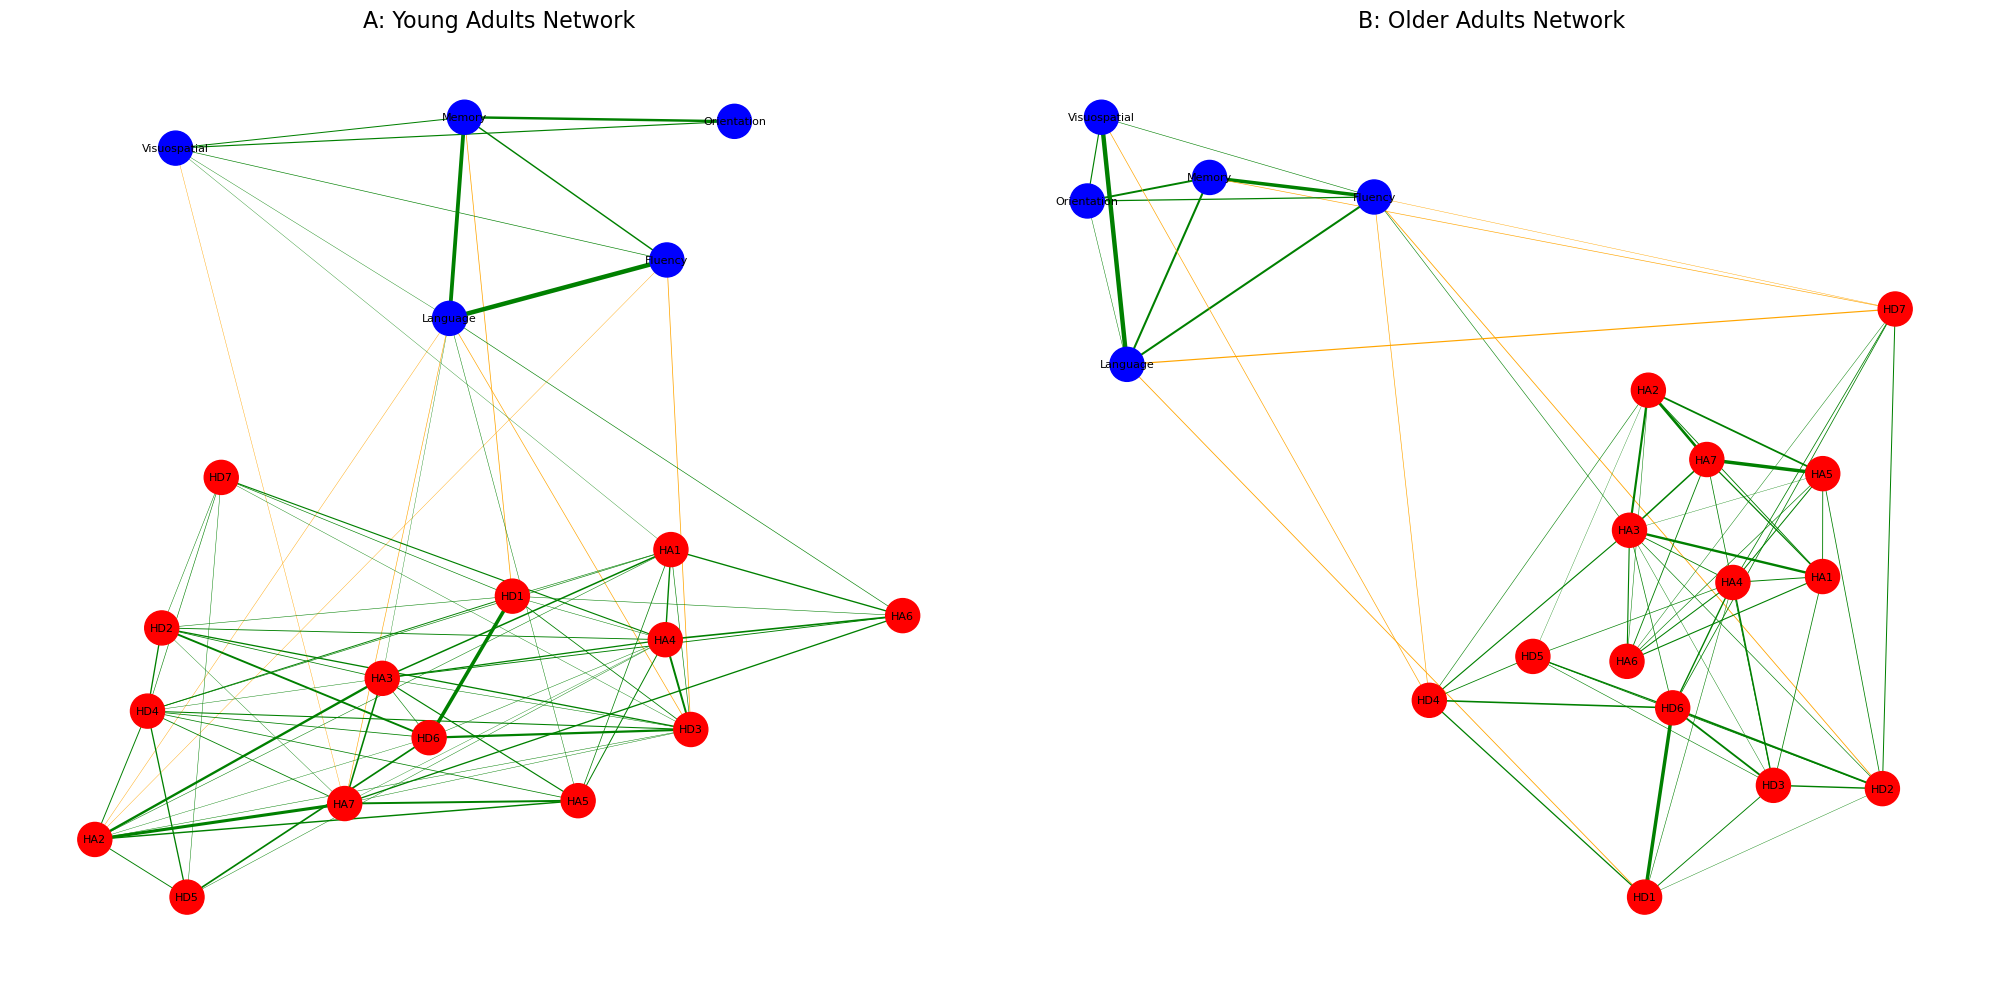

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.covariance import GraphicalLassoCV
from sklearn.preprocessing import StandardScaler

# Preprocessing Function
def preprocess_data(data, nodes, covariates):
    data = data.dropna(subset=nodes)
    for covariate in covariates:
        if covariate in data.columns:
            data[covariate].fillna(data[covariate].mean(), inplace=True)
    scaler = StandardScaler()
    data[covariates] = scaler.fit_transform(data[covariates])
    for node in nodes:
        X = data[covariates].values
        y = data[node].values
        ridge_reg_param = 1e-5
        XtX = np.dot(X.T, X) + ridge_reg_param * np.eye(X.shape[1])
        Xty = np.dot(X.T, y)
        beta = np.linalg.solve(XtX, Xty)
        data[node] = y - np.dot(X, beta)
    return data

# Construct Partial Correlation Network with EBIC Threshold
def construct_partial_correlation_network(data, nodes):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[nodes])
    model = GraphicalLassoCV()
    model.fit(scaled_data)
    
    best_alpha = model.alpha_  # Best alpha from EBIC
    print(f"Selected Lambda (Alpha) via EBIC: {best_alpha}")
    
    precision_matrix = model.precision_
    partial_corr_matrix = -precision_matrix / np.sqrt(
        np.outer(np.diag(precision_matrix), np.diag(precision_matrix))
    )
    np.fill_diagonal(partial_corr_matrix, 0)
    
    # Apply threshold based on EBIC-selected alpha
    threshold = best_alpha
    partial_corr_matrix[np.abs(partial_corr_matrix) < threshold] = 0
    return pd.DataFrame(partial_corr_matrix, index=nodes, columns=nodes)

# Create NetworkX Graph
def create_network(corr_matrix):
    G = nx.Graph()
    for i, node1 in enumerate(corr_matrix.columns):
        for j, node2 in enumerate(corr_matrix.columns):
            weight = corr_matrix.iloc[i, j]
            if weight != 0:
                G.add_edge(node1, node2, weight=weight)
    return G

# Compute Centralities
def compute_centralities(G, cognitive_nodes, affective_nodes):
    strength = {node: sum(abs(G[u][v]['weight']) for u, v in G.edges(node)) for node in G.nodes}
    betweenness = nx.betweenness_centrality(G, weight='weight')
    bridge_expected_influence = {
        node: sum(
            G[u][v]['weight'] for u, v in G.edges(node)
            if (node in cognitive_nodes and v in affective_nodes) or (node in affective_nodes and v in cognitive_nodes)
        )
        for node in G.nodes
    }
    return strength, betweenness, bridge_expected_influence

# Visualization for Combined Panels (A and B)
def visualize_combined_networks(G_young, G_old, cognitive_nodes, affective_nodes):
    scale_factor = 2
    pos_young = nx.spring_layout(G_young, seed=42, k=scale_factor / np.sqrt(len(G_young.nodes)))
    pos_old = nx.spring_layout(G_old, seed=42, k=scale_factor / np.sqrt(len(G_old.nodes)))

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Panel A: Young Adults
    plt.sca(axes[0])
    node_colors = ["blue" if node in cognitive_nodes else "red" for node in G_young.nodes]
    edge_colors = ['green' if G_young[u][v]['weight'] > 0 else 'orange' for u, v in G_young.edges()]
    edge_weights = [abs(G_young[u][v]['weight']) * 8 for u, v in G_young.edges()]
    nx.draw(
        G_young, pos_young, with_labels=True, node_color=node_colors, node_size=600,
        edge_color=edge_colors, width=edge_weights, font_size=8
    )
    plt.title("A: Young Adults Network", fontsize=16)

    # Panel B: Older Adults
    plt.sca(axes[1])
    node_colors = ["blue" if node in cognitive_nodes else "red" for node in G_old.nodes]
    edge_colors = ['green' if G_old[u][v]['weight'] > 0 else 'orange' for u, v in G_old.edges()]
    edge_weights = [abs(G_old[u][v]['weight']) * 8 for u, v in G_old.edges()]
    nx.draw(
        G_old, pos_old, with_labels=True, node_color=node_colors, node_size=600,
        edge_color=edge_colors, width=edge_weights, font_size=8
    )
    plt.title("B: Older Adults Network", fontsize=16)

    plt.tight_layout()
    plt.show()

# Main Analysis
file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\CamCAN_data\Final_Merged_CAMCAN_aseg_lh_volume.csv"
df = pd.read_csv(file_path)

cognitive_nodes = ['Memory', 'Fluency', 'Language', 'Visuospatial', 'Orientation']
affective_nodes = ['HD1', 'HD2', 'HD3', 'HD4', 'HD5', 'HD6', 'HD7', 'HA1', 'HA2', 'HA3', 'HA4', 'HA5', 'HA6', 'HA7']
nodes = cognitive_nodes + affective_nodes
covariates = ['sex', 'Education']

df_young = df[df['age'] <= 45].copy()
df_old = df[df['age'] >= 65].copy()

# Analyze Young Group
data_young = preprocess_data(df_young, nodes, covariates)
partial_corr_young = construct_partial_correlation_network(data_young, nodes)
G_young = create_network(partial_corr_young)

# Analyze Old Group
data_old = preprocess_data(df_old, nodes, covariates)
partial_corr_old = construct_partial_correlation_network(data_old, nodes)
G_old = create_network(partial_corr_old)

# Visualize Combined Panels
data_combined = {
    "Young": {"Graph": G_young},
    "Old": {"Graph": G_old}
}

visualize_combined_networks(
    G_young=G_young, 
    G_old=G_old, 
    cognitive_nodes=cognitive_nodes, 
    affective_nodes=affective_nodes
)


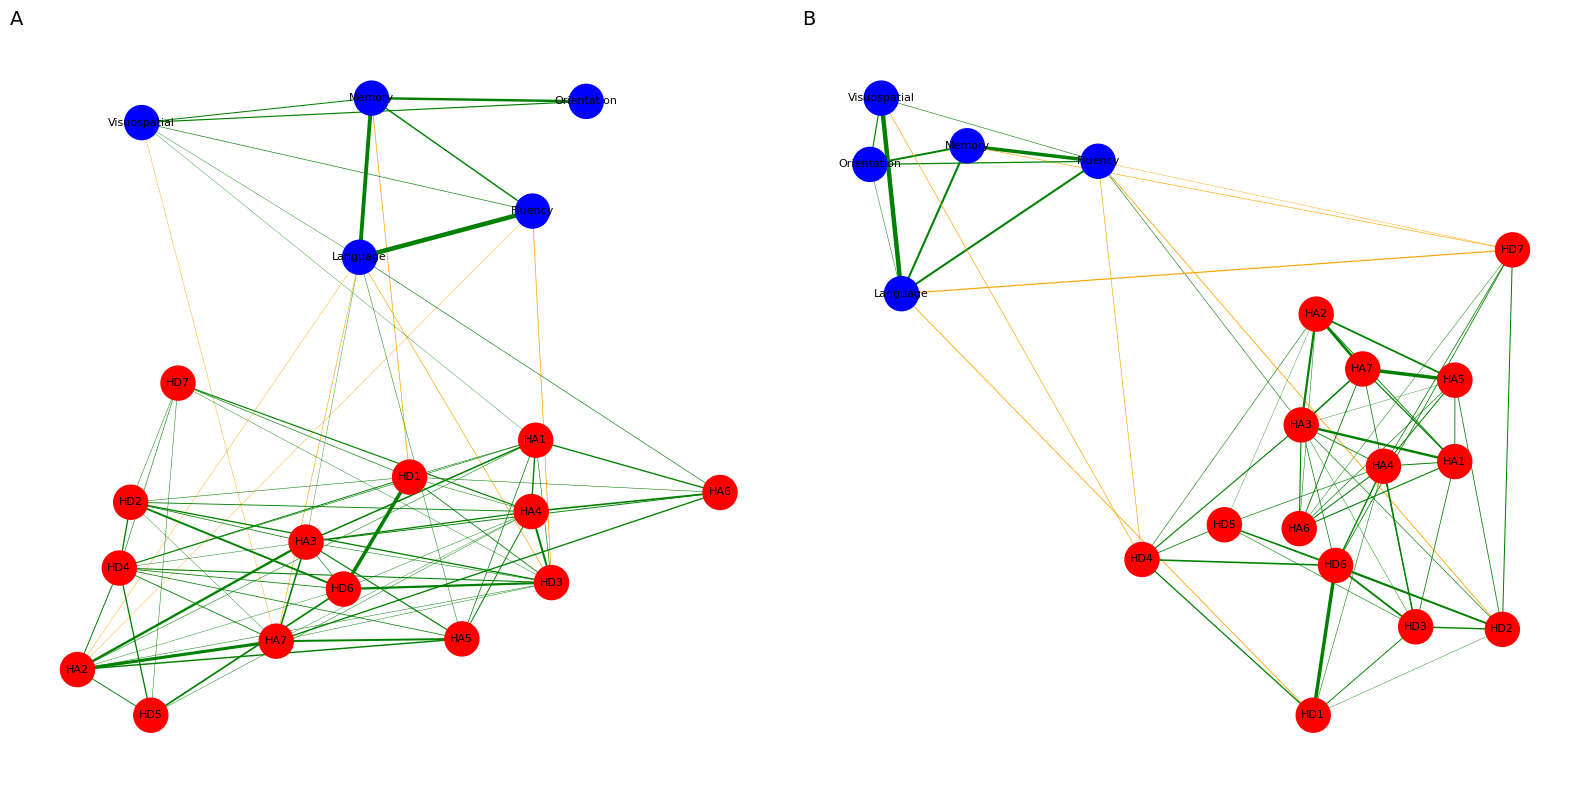

In [131]:
# Visualization for Combined Panels (A and B)
def visualize_combined_networks(G_young, G_old, cognitive_nodes, affective_nodes):
    scale_factor = 2
    pos_young = nx.spring_layout(G_young, seed=42, k=scale_factor / np.sqrt(len(G_young.nodes)))
    pos_old = nx.spring_layout(G_old, seed=42, k=scale_factor / np.sqrt(len(G_old.nodes)))

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Panel A: Young Adults
    ax = axes[0]
    plt.sca(ax)
    node_colors = ["blue" if node in cognitive_nodes else "red" for node in G_young.nodes]
    edge_colors = ['green' if G_young[u][v]['weight'] > 0 else 'orange' for u, v in G_young.edges()]
    edge_weights = [abs(G_young[u][v]['weight']) * 8 for u, v in G_young.edges()]
    nx.draw(
        G_young, pos_young, with_labels=True, node_color=node_colors, node_size=600,
        edge_color=edge_colors, width=edge_weights, font_size=8
    )
    ax.set_title("A", fontsize=14, loc='left')
    ax.set_frame_on(True)  # Enable black border
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    # Panel B: Older Adults
    ax = axes[1]
    plt.sca(ax)
    node_colors = ["blue" if node in cognitive_nodes else "red" for node in G_old.nodes]
    edge_colors = ['green' if G_old[u][v]['weight'] > 0 else 'orange' for u, v in G_old.edges()]
    edge_weights = [abs(G_old[u][v]['weight']) * 8 for u, v in G_old.edges()]
    nx.draw(
        G_old, pos_old, with_labels=True, node_color=node_colors, node_size=600,
        edge_color=edge_colors, width=edge_weights, font_size=8
    )
    ax.set_title("B", fontsize=14, loc='left')
    ax.set_frame_on(True)  # Enable black border
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    plt.tight_layout()
    plt.show()

# Main Visualization Call
visualize_combined_networks(
    G_young=G_young, 
    G_old=G_old, 
    cognitive_nodes=cognitive_nodes, 
    affective_nodes=affective_nodes
)


C:\Users\LAB-Mobile\AppData\Local\Temp\ipykernel_13104\2676014096.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[covariate].fillna(data[covariate].mean(), inplace=True)


Selected Lambda (Alpha) via EBIC: 0.030539147538078473


C:\Users\LAB-Mobile\AppData\Local\Temp\ipykernel_13104\2676014096.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[covariate].fillna(data[covariate].mean(), inplace=True)


Selected Lambda (Alpha) via EBIC: 0.029037185085977253


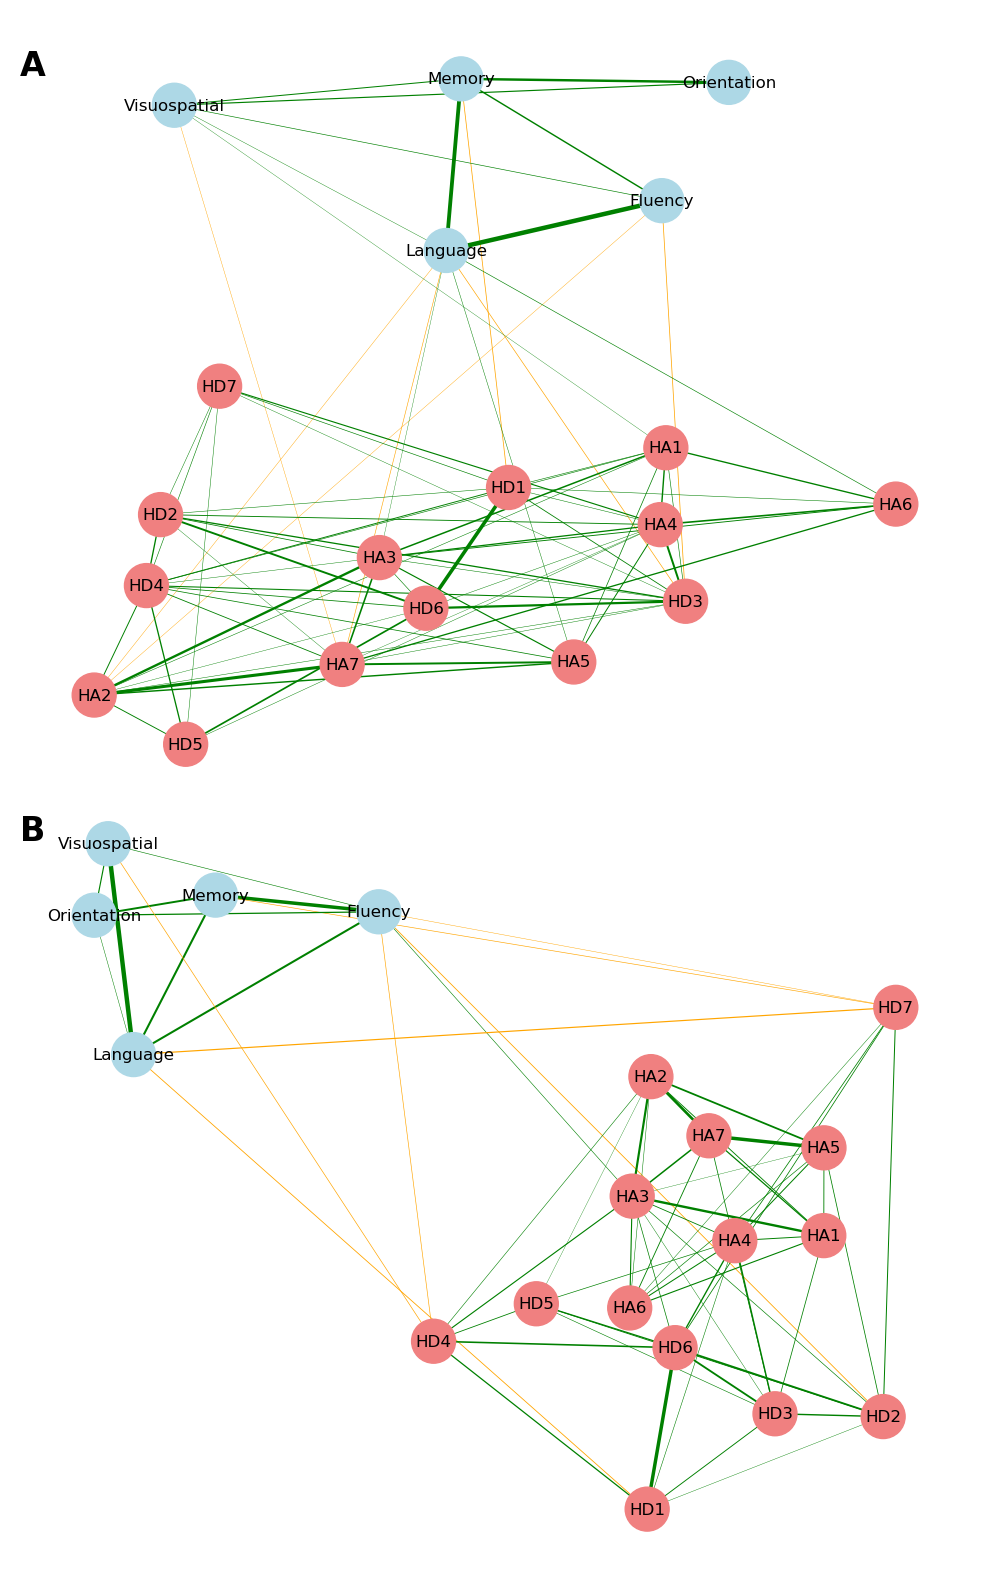

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.covariance import GraphicalLassoCV
from sklearn.preprocessing import StandardScaler

# Preprocessing Function
def preprocess_data(data, nodes, covariates):
    data = data.dropna(subset=nodes)
    for covariate in covariates:
        if covariate in data.columns:
            data[covariate].fillna(data[covariate].mean(), inplace=True)
    scaler = StandardScaler()
    data[covariates] = scaler.fit_transform(data[covariates])
    for node in nodes:
        X = data[covariates].values
        y = data[node].values
        ridge_reg_param = 1e-5
        XtX = np.dot(X.T, X) + ridge_reg_param * np.eye(X.shape[1])
        Xty = np.dot(X.T, y)
        beta = np.linalg.solve(XtX, Xty)
        data[node] = y - np.dot(X, beta)
    return data

# Construct Partial Correlation Network with EBIC Threshold
def construct_partial_correlation_network(data, nodes):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[nodes])
    model = GraphicalLassoCV()
    model.fit(scaled_data)
    
    best_alpha = model.alpha_  # Best alpha from EBIC
    print(f"Selected Lambda (Alpha) via EBIC: {best_alpha}")
    
    precision_matrix = model.precision_
    partial_corr_matrix = -precision_matrix / np.sqrt(
        np.outer(np.diag(precision_matrix), np.diag(precision_matrix))
    )
    np.fill_diagonal(partial_corr_matrix, 0)
    
    # Apply threshold based on EBIC-selected alpha
    threshold = best_alpha
    partial_corr_matrix[np.abs(partial_corr_matrix) < threshold] = 0
    return pd.DataFrame(partial_corr_matrix, index=nodes, columns=nodes)

# Create NetworkX Graph
def create_network(corr_matrix):
    G = nx.Graph()
    for i, node1 in enumerate(corr_matrix.columns):
        for j, node2 in enumerate(corr_matrix.columns):
            weight = corr_matrix.iloc[i, j]
            if weight != 0:
                G.add_edge(node1, node2, weight=weight)
    return G

# Compute Centralities
def compute_centralities(G, cognitive_nodes, affective_nodes):
    strength = {node: sum(abs(G[u][v]['weight']) for u, v in G.edges(node)) for node in G.nodes}
    betweenness = nx.betweenness_centrality(G, weight='weight')
    bridge_expected_influence = {
        node: sum(
            G[u][v]['weight'] for u, v in G.edges(node)
            if (node in cognitive_nodes and v in affective_nodes) or (node in affective_nodes and v in cognitive_nodes)
        )
        for node in G.nodes
    }
    return strength, betweenness, bridge_expected_influence

def visualize_combined_networks(G_young, G_old, cognitive_nodes, affective_nodes):
    scale_factor = 2
    pos_young = nx.spring_layout(G_young, seed=42, k=scale_factor / np.sqrt(len(G_young.nodes)))
    pos_old = nx.spring_layout(G_old, seed=42, k=scale_factor / np.sqrt(len(G_old.nodes)))

    fig, axes = plt.subplots(2, 1, figsize=(10, 16))

    # Panel A: Young Adults
    ax = axes[0]
    plt.sca(ax)

    node_colors = ["lightblue" if node in cognitive_nodes else "lightcoral" for node in G_young.nodes] # אדום בהיר
    edge_colors = ['green' if G_young[u][v]['weight'] > 0 else 'orange' for u, v in G_young.edges()]
    edge_weights = [abs(G_young[u][v]['weight']) * 8 for u, v in G_young.edges()]

    nx.draw(
        G_young, pos_young, with_labels=True, node_color=node_colors, node_size=1000,
        edge_color=edge_colors, width=edge_weights, font_size=12,
        font_color="black"
    )

    ax.text(0.01, 0.95, "A", transform=ax.transAxes, fontsize=24, fontweight='bold', verticalalignment='top')  # הוספת "A"
    ax.set_frame_on(True)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    

    # Panel B: Older Adults
    ax = axes[1]
    plt.sca(ax)

    node_colors = ["lightblue" if node in cognitive_nodes else "lightcoral" for node in G_old.nodes]  # אדום בהיר
    edge_colors = ['green' if G_old[u][v]['weight'] > 0 else 'orange' for u, v in G_old.edges()]
    edge_weights = [abs(G_old[u][v]['weight']) * 8 for u, v in G_old.edges()]

    nx.draw(
        G_old, pos_old, with_labels=True, node_color=node_colors, node_size=1000,
        edge_color=edge_colors, width=edge_weights, font_size=12,
        font_color="black"
    )

    ax.text(0.01, 0.95, "B", transform=ax.transAxes, fontsize=24, fontweight='bold', verticalalignment='top')  # הוספת "B"
    ax.set_frame_on(True)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=-0.05)
    plt.show()

# Main Analysis
file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\CamCAN_data\Final_Merged_CAMCAN_aseg_lh_volume.csv"
df = pd.read_csv(file_path)

cognitive_nodes = ['Memory', 'Fluency', 'Language', 'Visuospatial', 'Orientation']
affective_nodes = ['HD1', 'HD2', 'HD3', 'HD4', 'HD5', 'HD6', 'HD7', 'HA1', 'HA2', 'HA3', 'HA4', 'HA5', 'HA6', 'HA7']
nodes = cognitive_nodes + affective_nodes
covariates = ['sex', 'Education']

df_young = df[df['age'] <= 45].copy()
df_old = df[df['age'] >= 65].copy()

# Analyze Young Group
data_young = preprocess_data(df_young, nodes, covariates)
partial_corr_young = construct_partial_correlation_network(data_young, nodes)
G_young = create_network(partial_corr_young)

# Analyze Old Group
data_old = preprocess_data(df_old, nodes, covariates)
partial_corr_old = construct_partial_correlation_network(data_old, nodes)
G_old = create_network(partial_corr_old)

# Visualize Combined Panels
data_combined = {
    "Young": {"Graph": G_young},
    "Old": {"Graph": G_old}
}

visualize_combined_networks(
    G_young=G_young, 
    G_old=G_old, 
    cognitive_nodes=cognitive_nodes, 
    affective_nodes=affective_nodes
)


Analyzing Young group...
Number of participants in Young group: 756


C:\Users\LAB-Mobile\AppData\Local\Temp\ipykernel_13104\775745474.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[covariate].fillna(data[covariate].mean(), inplace=True)



Analyzing Old group...
Number of participants in Old group: 1230


C:\Users\LAB-Mobile\AppData\Local\Temp\ipykernel_13104\775745474.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[covariate].fillna(data[covariate].mean(), inplace=True)


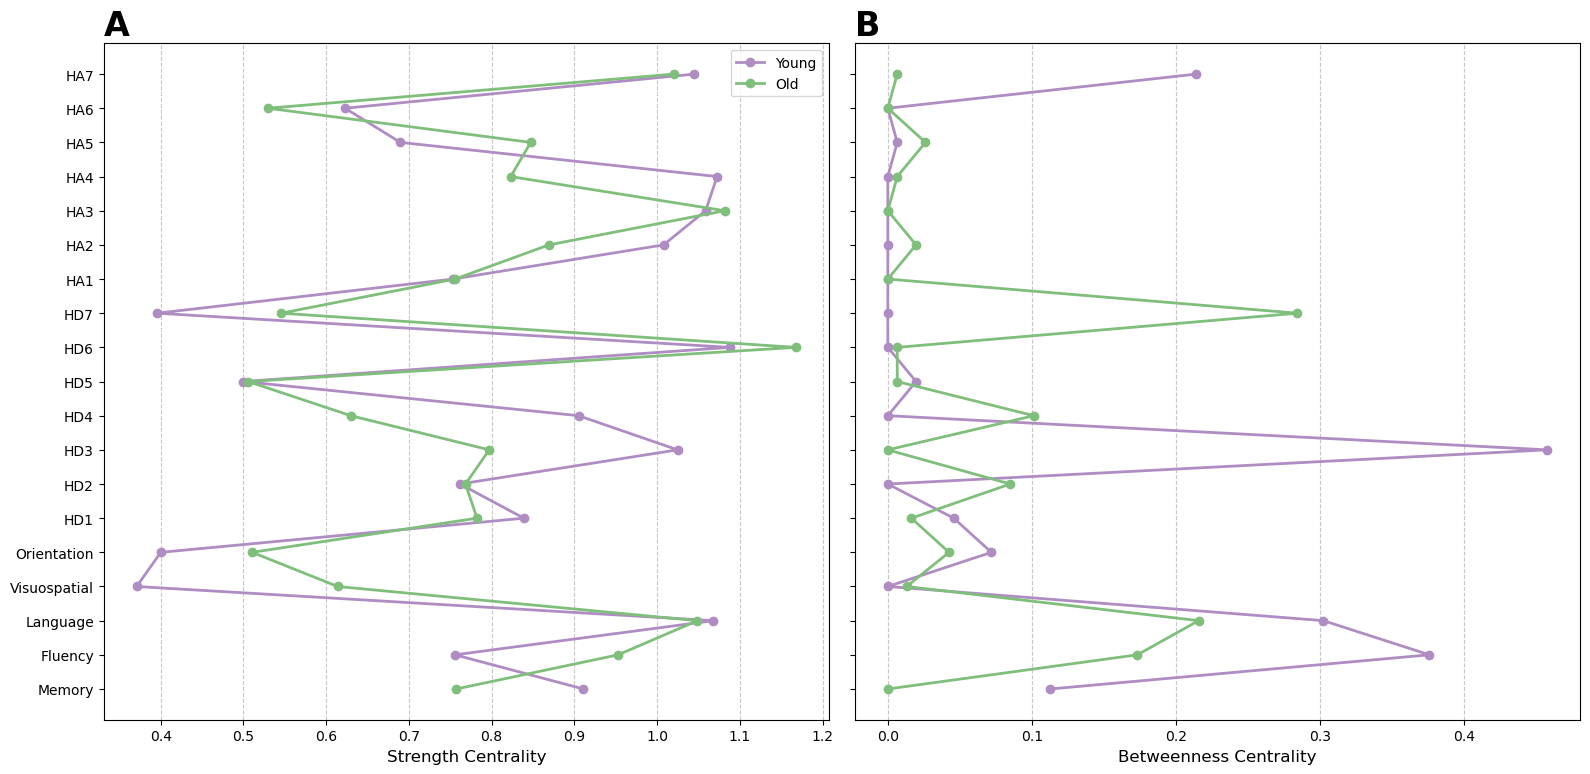


Top 5 nodes for group Young:

Strength:
  HD6: 1.0877
  HA4: 1.0726
  Language: 1.0679
  HA3: 1.0586
  HA7: 1.0452

Betweenness:
  HD3: 0.4575
  Fluency: 0.3758
  Language: 0.3023
  HA7: 0.2141
  Memory: 0.1127

Top 5 nodes for group Old:

Strength:
  HD6: 1.1678
  HA3: 1.0818
  Language: 1.0488
  HA7: 1.0208
  Fluency: 0.9529

Betweenness:
  HD7: 0.2843
  Language: 0.2157
  Fluency: 0.1732
  HD4: 0.1013
  HD2: 0.0850


In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.covariance import GraphicalLassoCV
from sklearn.preprocessing import StandardScaler

# Preprocessing Function
def preprocess_data(data, nodes, covariates):
    data = data.dropna(subset=nodes)
    for covariate in covariates:
        if covariate in data.columns:
            data[covariate].fillna(data[covariate].mean(), inplace=True)
    scaler = StandardScaler()
    data[covariates] = scaler.fit_transform(data[covariates])
    for node in nodes:
        X = data[covariates].values
        y = data[node].values
        ridge_reg_param = 1e-5
        XtX = np.dot(X.T, X) + ridge_reg_param * np.eye(X.shape[1])
        Xty = np.dot(X.T, y)
        beta = np.linalg.solve(XtX, Xty)
        data[node] = y - np.dot(X, beta)
    return data

# Construct Partial Correlation Network
def construct_partial_correlation_network(data, nodes):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[nodes])
    model = GraphicalLassoCV()
    model.fit(scaled_data)
    precision_matrix = model.precision_
    partial_corr_matrix = -precision_matrix / np.sqrt(
        np.outer(np.diag(precision_matrix), np.diag(precision_matrix))
    )
    np.fill_diagonal(partial_corr_matrix, 0)
    return pd.DataFrame(partial_corr_matrix, index=nodes, columns=nodes)

# Create NetworkX Graph
def create_network(corr_matrix):
    G = nx.Graph()
    for i, node1 in enumerate(corr_matrix.columns):
        for j, node2 in enumerate(corr_matrix.columns):
            weight = corr_matrix.iloc[i, j]
            if weight != 0:
                G.add_edge(node1, node2, weight=weight)
    return G

# Compute Centralities (Strength and Betweenness) with a constant shift for betweenness
def compute_centralities(G):
    # Strength: sum of absolute weights (unchanged)
    strength = {node: sum(abs(G[u][v]['weight']) for u, v in G.edges(node)) for node in G.nodes}
    
    # Compute the constant shift: if there is any negative weight, add the absolute value of the most negative one.
    all_weights = [d['weight'] for _, _, d in G.edges(data=True)]
    shift = -min(all_weights) if min(all_weights) < 0 else 0
    
    # Use a lambda function for the weight so that the betweenness algorithm sees nonnegative values.
    betweenness = nx.betweenness_centrality(G, weight=lambda u, v, d: d['weight'] + shift)
    
    return strength, betweenness

# Visualization of Centrality Comparison
def visualize_centralities_comparison(centrality_data_young, centrality_data_old, nodes, title):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
    centrality_names = ["Strength", "Betweenness"]
    colors = {'Young': '#af8dc3', 'Old': '#7fbf7b'} # צבעים חדשים - סגול וירוק

    for i, centrality_name in enumerate(centrality_names):
        young_values = [centrality_data_young[centrality_name].get(node, 0) for node in nodes]
        old_values = [centrality_data_old[centrality_name].get(node, 0) for node in nodes]

        axs[i].plot(young_values, range(len(nodes)), marker='o', color=colors['Young'], linewidth=2, linestyle='-', label='Young')
        axs[i].plot(old_values, range(len(nodes)), marker='o', color=colors['Old'], linewidth=2, linestyle='-', label='Old')

        axs[i].set_yticks(range(len(nodes)))
        axs[i].set_yticklabels(nodes, fontsize=10)
        axs[i].set_title(f"{chr(ord('A') + i)}", loc='left', fontsize=24, fontweight='bold')
        axs[i].invert_yaxis()
        axs[i].set_xlabel(f"{centrality_name} Centrality", fontsize=12)
        axs[i].grid(axis='x', linestyle='--', alpha=0.7)
        if i == 0:
            axs[i].legend(loc='best', fontsize=10)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Function to print the top 5 nodes for each centrality measure for a given group
def print_top5_centralities(centrality_data, group):
    print(f"\nTop 5 nodes for group {group}:")
    for measure in ["Strength", "Betweenness"]:
        # sort nodes by centrality measure in descending order
        sorted_nodes = sorted(centrality_data[group][measure].items(), key=lambda x: x[1], reverse=True)
        print(f"\n{measure}:")
        for node, value in sorted_nodes[:5]:
            print(f"  {node}: {value:.4f}")

# Main Analysis
file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\CamCAN_data\Final_Merged_CAMCAN_aseg_lh_volume.csv"
df = pd.read_csv(file_path)

cognitive_nodes = ['Memory', 'Fluency', 'Language', 'Visuospatial', 'Orientation']
affective_nodes = ['HD1', 'HD2', 'HD3', 'HD4', 'HD5', 'HD6', 'HD7', 'HA1', 'HA2', 'HA3', 'HA4', 'HA5', 'HA6', 'HA7']
nodes = cognitive_nodes + affective_nodes
covariates = ['sex', 'Education']

df_young = df[df['age'] <= 45].copy()
df_old = df[df['age'] >= 65].copy()

centrality_data = {}
for group, data in zip(["Young", "Old"], [df_young, df_old]):
    print(f"\nAnalyzing {group} group...")
    data = preprocess_data(data, nodes, covariates)
    print(f"Number of participants in {group} group: {data.shape[0]}")

    partial_corr = construct_partial_correlation_network(data, nodes)
    G = create_network(partial_corr)

    strength, betweenness = compute_centralities(G)  # Get centralities

    centrality_data[group] = {
        "Strength": strength,
        "Betweenness": betweenness,
    }

# Visualization of Centrality Comparison
visualize_centralities_comparison(
    centrality_data_young=centrality_data["Young"],
    centrality_data_old=centrality_data["Old"],
    nodes=nodes,
    title=""
)

# Print the top 5 nodes for each centrality measure in each group
print_top5_centralities(centrality_data, "Young")
print_top5_centralities(centrality_data, "Old")



Analyzing Young group...
Number of participants in Young group: 756


C:\Users\LAB-Mobile\AppData\Local\Temp\ipykernel_13104\2442694029.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[covariate].fillna(data[covariate].mean(), inplace=True)



Analyzing Old group...
Number of participants in Old group: 1230


C:\Users\LAB-Mobile\AppData\Local\Temp\ipykernel_13104\2442694029.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[covariate].fillna(data[covariate].mean(), inplace=True)


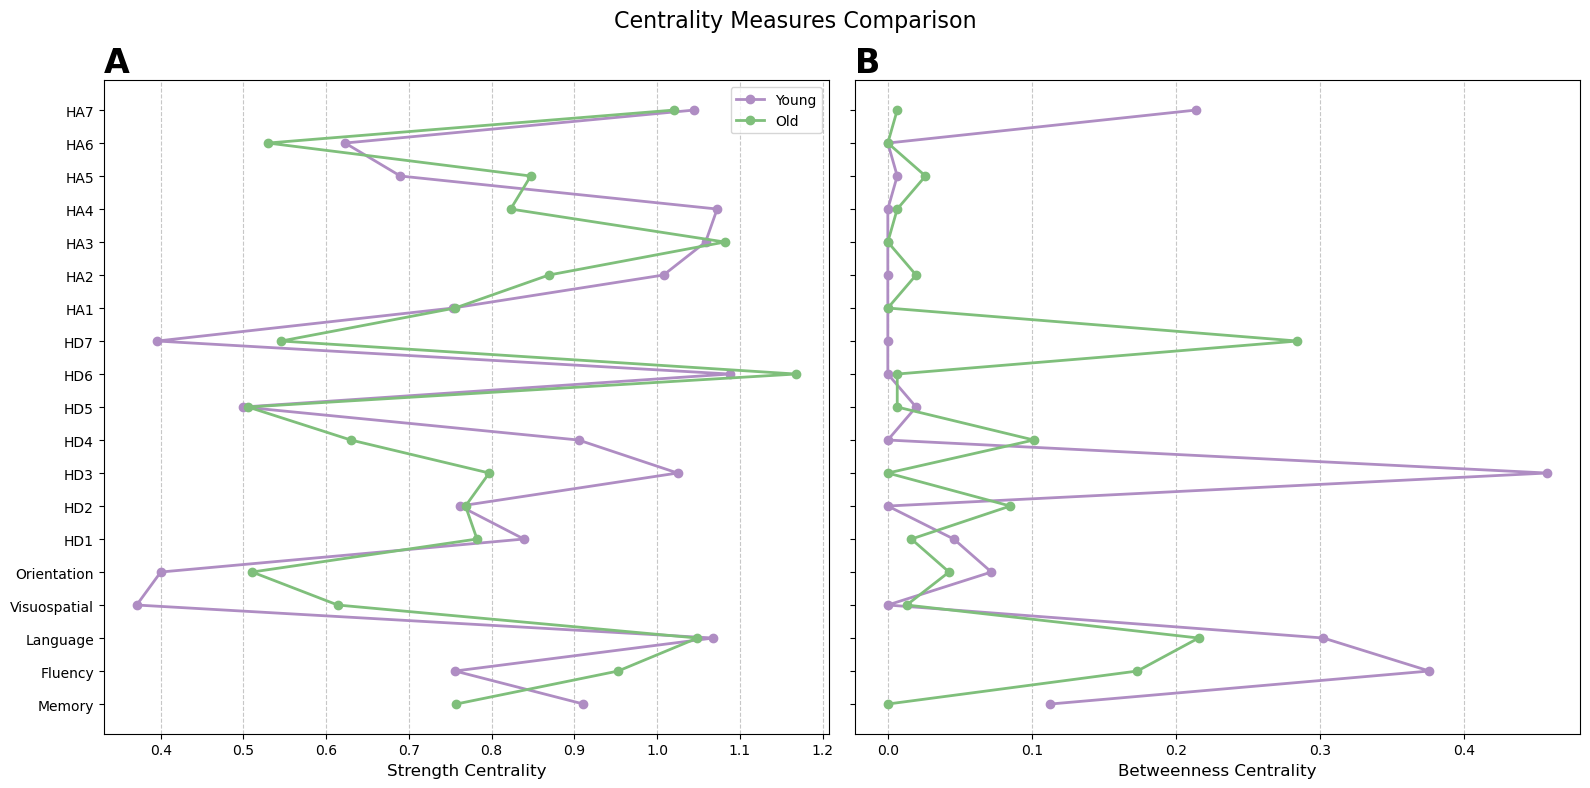


Permutation Test for Betweenness in Young group:
Observed Difference (mean set1 - mean set2): 0.0432
P-Value: 0.5751

Permutation Test for Betweenness in Old group:
Observed Difference (mean set1 - mean set2): 0.0630
P-Value: 0.1158

Spearman correlation for Betweenness between Young and Old:
Spearman Rho = 0.0654, P-Value = 0.7903


In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.covariance import GraphicalLassoCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr

# Preprocessing Function
def preprocess_data(data, nodes, covariates):
    data = data.dropna(subset=nodes)
    for covariate in covariates:
        if covariate in data.columns:
            data[covariate].fillna(data[covariate].mean(), inplace=True)
    scaler = StandardScaler()
    data[covariates] = scaler.fit_transform(data[covariates])
    for node in nodes:
        X = data[covariates].values
        y = data[node].values
        ridge_reg_param = 1e-5
        XtX = np.dot(X.T, X) + ridge_reg_param * np.eye(X.shape[1])
        Xty = np.dot(X.T, y)
        beta = np.linalg.solve(XtX, Xty)
        data[node] = y - np.dot(X, beta)
    return data

# Construct Partial Correlation Network
def construct_partial_correlation_network(data, nodes):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[nodes])
    model = GraphicalLassoCV()
    model.fit(scaled_data)
    precision_matrix = model.precision_
    partial_corr_matrix = -precision_matrix / np.sqrt(
        np.outer(np.diag(precision_matrix), np.diag(precision_matrix))
    )
    np.fill_diagonal(partial_corr_matrix, 0)
    return pd.DataFrame(partial_corr_matrix, index=nodes, columns=nodes)

# Create NetworkX Graph
def create_network(corr_matrix):
    G = nx.Graph()
    for i, node1 in enumerate(corr_matrix.columns):
        for j, node2 in enumerate(corr_matrix.columns):
            weight = corr_matrix.iloc[i, j]
            if weight != 0:
                G.add_edge(node1, node2, weight=weight)
    return G

# Compute Centralities (Strength and Betweenness) with a constant shift for betweenness
def compute_centralities(G):
    # Strength: sum of absolute weights (unchanged)
    strength = {node: sum(abs(G[u][v]['weight']) for u, v in G.edges(node)) for node in G.nodes}
    
    # Compute the constant shift: if any negative weight exists, shift by its absolute value.
    all_weights = [d['weight'] for _, _, d in G.edges(data=True)]
    shift = -min(all_weights) if min(all_weights) < 0 else 0
    
    # Betweenness using the shifted weights
    betweenness = nx.betweenness_centrality(G, weight=lambda u, v, d: d['weight'] + shift)
    
    return strength, betweenness

# Visualization of Centrality Comparison
def visualize_centralities_comparison(centrality_data_young, centrality_data_old, nodes, title):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
    centrality_names = ["Strength", "Betweenness"]
    colors = {'Young': '#af8dc3', 'Old': '#7fbf7b'}

    for i, centrality_name in enumerate(centrality_names):
        young_values = [centrality_data_young[centrality_name].get(node, 0) for node in nodes]
        old_values = [centrality_data_old[centrality_name].get(node, 0) for node in nodes]

        axs[i].plot(young_values, range(len(nodes)), marker='o', color=colors['Young'], linewidth=2, linestyle='-', label='Young')
        axs[i].plot(old_values, range(len(nodes)), marker='o', color=colors['Old'], linewidth=2, linestyle='-', label='Old')

        axs[i].set_yticks(range(len(nodes)))
        axs[i].set_yticklabels(nodes, fontsize=10)
        axs[i].set_title(f"{chr(ord('A') + i)}", loc='left', fontsize=24, fontweight='bold')
        axs[i].invert_yaxis()
        axs[i].set_xlabel(f"{centrality_name} Centrality", fontsize=12)
        axs[i].grid(axis='x', linestyle='--', alpha=0.7)
        if i == 0:
            axs[i].legend(loc='best', fontsize=10)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Permutation Test for Betweenness (with shifted weights)
def permutation_test_betweenness(centrality_data, group, node_set1, node_set2, n_permutations=5000):
    """
    Perform a permutation test for betweenness centrality differences between two sets of nodes.
    """
    betweenness = centrality_data[group]["Betweenness"]
    values1 = np.array([betweenness.get(node, 0) for node in node_set1])
    values2 = np.array([betweenness.get(node, 0) for node in node_set2])
    
    observed_diff = np.mean(values1) - np.mean(values2)
    combined = np.concatenate((values1, values2))
    n1 = len(values1)
    
    perm_diffs = []
    for _ in range(n_permutations):
        np.random.shuffle(combined)
        perm1 = combined[:n1]
        perm2 = combined[n1:]
        perm_diffs.append(np.mean(perm1) - np.mean(perm2))
    perm_diffs = np.array(perm_diffs)
    
    p_value = (np.sum(np.abs(perm_diffs) >= np.abs(observed_diff)) + 1) / (n_permutations + 1)
    
    print(f"\nPermutation Test for Betweenness in {group} group:")
    print(f"Observed Difference (mean set1 - mean set2): {observed_diff:.4f}")
    print(f"P-Value: {p_value:.4f}")
    
    return observed_diff, p_value

# Spearman Correlation for Betweenness Between Groups
def compute_spearman_betweenness(centrality_data_young, centrality_data_old, nodes):
    betweenness_young = [centrality_data_young["Betweenness"].get(node, 0) for node in nodes]
    betweenness_old = [centrality_data_old["Betweenness"].get(node, 0) for node in nodes]
    rho, p_value = spearmanr(betweenness_young, betweenness_old)
    
    print("\nSpearman correlation for Betweenness between Young and Old:")
    print(f"Spearman Rho = {rho:.4f}, P-Value = {p_value:.4f}")
    
    return rho, p_value

# Main Analysis
file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\CamCAN_data\Final_Merged_CAMCAN_aseg_lh_volume.csv"
df = pd.read_csv(file_path)

cognitive_nodes = ['Memory', 'Fluency', 'Language', 'Visuospatial', 'Orientation']
affective_nodes = ['HD1', 'HD2', 'HD3', 'HD4', 'HD5', 'HD6', 'HD7', 'HA1', 'HA2', 'HA3', 'HA4', 'HA5', 'HA6', 'HA7']
nodes = cognitive_nodes + affective_nodes
covariates = ['sex', 'Education']

df_young = df[df['age'] <= 45].copy()
df_old = df[df['age'] >= 65].copy()

centrality_data = {}
for group, data in zip(["Young", "Old"], [df_young, df_old]):
    print(f"\nAnalyzing {group} group...")
    data = preprocess_data(data, nodes, covariates)
    print(f"Number of participants in {group} group: {data.shape[0]}")
    
    partial_corr = construct_partial_correlation_network(data, nodes)
    G = create_network(partial_corr)
    
    strength, betweenness = compute_centralities(G)
    
    centrality_data[group] = {
        "Strength": strength,
        "Betweenness": betweenness
    }

# Visualization of Centrality Comparison
visualize_centralities_comparison(
    centrality_data_young=centrality_data["Young"],
    centrality_data_old=centrality_data["Old"],
    nodes=nodes,
    title="Centrality Measures Comparison"
)

# Define node sets for permutation testing:
# Assume "HD" nodes represent depression-related and "HA" nodes represent anxiety-related.
depression_nodes = [node for node in affective_nodes if node.startswith("HD")]
anxiety_nodes = [node for node in affective_nodes if node.startswith("HA")]

# Perform permutation tests for betweenness in each group
obs_diff_young, p_val_young = permutation_test_betweenness(centrality_data, "Young", depression_nodes, anxiety_nodes, n_permutations=5000)
obs_diff_old, p_val_old = permutation_test_betweenness(centrality_data, "Old", depression_nodes, anxiety_nodes, n_permutations=5000)

# Compute Spearman correlation for betweenness between Young and Old groups
rho, p_val = compute_spearman_betweenness(centrality_data["Young"], centrality_data["Old"], nodes)



Analyzing Young group...
Number of participants in Young group: 756


C:\Users\LAB-Mobile\AppData\Local\Temp\ipykernel_13104\698911636.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[covariate].fillna(data[covariate].mean(), inplace=True)



Analyzing Old group...
Number of participants in Old group: 1230


C:\Users\LAB-Mobile\AppData\Local\Temp\ipykernel_13104\698911636.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[covariate].fillna(data[covariate].mean(), inplace=True)


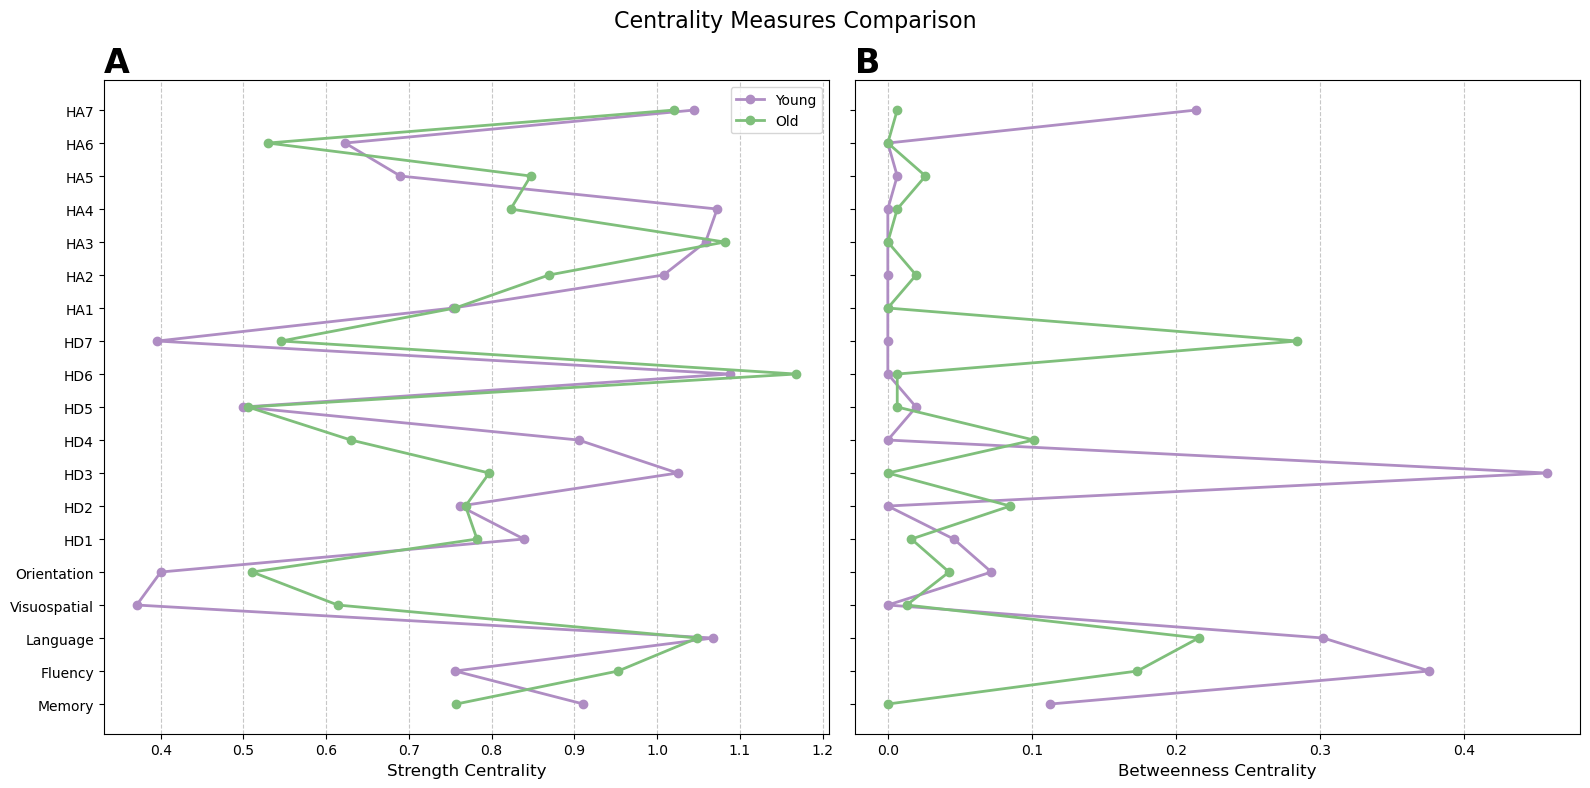


Permutation Test for Raw Betweenness in Young group:
Observed Difference (mean set1 - mean set2): 0.0532
P-Value: 0.7015

Permutation Test for Raw Betweenness in Old group:
Observed Difference (mean set1 - mean set2): 0.3254
P-Value: 0.0336

Spearman correlation for Raw Betweenness between Young and Old:
Spearman Rho = 0.3301, P-Value = 0.1675


In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.covariance import GraphicalLassoCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr

# Preprocessing Function
def preprocess_data(data, nodes, covariates):
    data = data.dropna(subset=nodes)
    for covariate in covariates:
        if covariate in data.columns:
            data[covariate].fillna(data[covariate].mean(), inplace=True)
    scaler = StandardScaler()
    data[covariates] = scaler.fit_transform(data[covariates])
    for node in nodes:
        X = data[covariates].values
        y = data[node].values
        ridge_reg_param = 1e-5
        XtX = np.dot(X.T, X) + ridge_reg_param * np.eye(X.shape[1])
        Xty = np.dot(X.T, y)
        beta = np.linalg.solve(XtX, Xty)
        data[node] = y - np.dot(X, beta)
    return data

# Construct Partial Correlation Network
def construct_partial_correlation_network(data, nodes):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[nodes])
    model = GraphicalLassoCV()
    model.fit(scaled_data)
    precision_matrix = model.precision_
    partial_corr_matrix = -precision_matrix / np.sqrt(
        np.outer(np.diag(precision_matrix), np.diag(precision_matrix))
    )
    np.fill_diagonal(partial_corr_matrix, 0)
    return pd.DataFrame(partial_corr_matrix, index=nodes, columns=nodes)

# Create NetworkX Graph
def create_network(corr_matrix):
    G = nx.Graph()
    for i, node1 in enumerate(corr_matrix.columns):
        for j, node2 in enumerate(corr_matrix.columns):
            weight = corr_matrix.iloc[i, j]
            if weight != 0:
                G.add_edge(node1, node2, weight=weight)
    return G

# Compute Centralities (with shifted betweenness for other analyses)
def compute_centralities(G):
    # Strength: sum of absolute weights
    strength = {node: sum(abs(G[u][v]['weight']) for u, v in G.edges(node)) for node in G.nodes}
    
    # Shifted Betweenness (for previous analyses)
    all_weights = [d['weight'] for _, _, d in G.edges(data=True)]
    shift = -min(all_weights) if min(all_weights) < 0 else 0
    shifted_betweenness = nx.betweenness_centrality(G, weight=lambda u, v, d: d['weight'] + shift)
    
    # Raw Betweenness (without any shift)
    raw_betweenness = nx.betweenness_centrality(G, weight='weight')
    
    return strength, shifted_betweenness, raw_betweenness

# Visualization of Centrality Comparison (using shifted betweenness)
def visualize_centralities_comparison(centrality_data_young, centrality_data_old, nodes, title):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
    centrality_names = ["Strength", "Betweenness"]
    colors = {'Young': '#af8dc3', 'Old': '#7fbf7b'}

    for i, centrality_name in enumerate(centrality_names):
        young_values = [centrality_data_young[centrality_name].get(node, 0) for node in nodes]
        old_values = [centrality_data_old[centrality_name].get(node, 0) for node in nodes]

        axs[i].plot(young_values, range(len(nodes)), marker='o', color=colors['Young'], linewidth=2, linestyle='-', label='Young')
        axs[i].plot(old_values, range(len(nodes)), marker='o', color=colors['Old'], linewidth=2, linestyle='-', label='Old')

        axs[i].set_yticks(range(len(nodes)))
        axs[i].set_yticklabels(nodes, fontsize=10)
        axs[i].set_title(f"{chr(ord('A') + i)}", loc='left', fontsize=24, fontweight='bold')
        axs[i].invert_yaxis()
        axs[i].set_xlabel(f"{centrality_name} Centrality", fontsize=12)
        axs[i].grid(axis='x', linestyle='--', alpha=0.7)
        if i == 0:
            axs[i].legend(loc='best', fontsize=10)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Permutation Test for Raw Betweenness (comparing two node sets)
def permutation_test_raw_betweenness(centrality_data, group, node_set1, node_set2, n_permutations=5000):
    """
    Perform a permutation test for raw betweenness centrality differences between two sets of nodes.
    """
    betweenness = centrality_data[group]["Raw Betweenness"]
    values1 = np.array([betweenness.get(node, 0) for node in node_set1])
    values2 = np.array([betweenness.get(node, 0) for node in node_set2])
    
    observed_diff = np.mean(values1) - np.mean(values2)
    combined = np.concatenate((values1, values2))
    n1 = len(values1)
    
    perm_diffs = []
    for _ in range(n_permutations):
        np.random.shuffle(combined)
        perm1 = combined[:n1]
        perm2 = combined[n1:]
        perm_diffs.append(np.mean(perm1) - np.mean(perm2))
    perm_diffs = np.array(perm_diffs)
    
    p_value = (np.sum(np.abs(perm_diffs) >= np.abs(observed_diff)) + 1) / (n_permutations + 1)
    
    print(f"\nPermutation Test for Raw Betweenness in {group} group:")
    print(f"Observed Difference (mean set1 - mean set2): {observed_diff:.4f}")
    print(f"P-Value: {p_value:.4f}")
    
    return observed_diff, p_value

# Spearman Correlation for Raw Betweenness Between Groups
def compute_spearman_raw_betweenness(centrality_data_young, centrality_data_old, nodes):
    raw_betw_young = [centrality_data_young["Raw Betweenness"].get(node, 0) for node in nodes]
    raw_betw_old = [centrality_data_old["Raw Betweenness"].get(node, 0) for node in nodes]
    rho, p_value = spearmanr(raw_betw_young, raw_betw_old)
    
    print("\nSpearman correlation for Raw Betweenness between Young and Old:")
    print(f"Spearman Rho = {rho:.4f}, P-Value = {p_value:.4f}")
    
    return rho, p_value

# Main Analysis
file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\CamCAN_data\Final_Merged_CAMCAN_aseg_lh_volume.csv"
df = pd.read_csv(file_path)

cognitive_nodes = ['Memory', 'Fluency', 'Language', 'Visuospatial', 'Orientation']
affective_nodes = ['HD1', 'HD2', 'HD3', 'HD4', 'HD5', 'HD6', 'HD7', 'HA1', 'HA2', 'HA3', 'HA4', 'HA5', 'HA6', 'HA7']
nodes = cognitive_nodes + affective_nodes
covariates = ['sex', 'Education']

df_young = df[df['age'] <= 45].copy()
df_old = df[df['age'] >= 65].copy()

# We'll store three measures per group: Strength, Shifted Betweenness, and Raw Betweenness.
centrality_data = {}
for group, data in zip(["Young", "Old"], [df_young, df_old]):
    print(f"\nAnalyzing {group} group...")
    data = preprocess_data(data, nodes, covariates)
    print(f"Number of participants in {group} group: {data.shape[0]}")
    
    partial_corr = construct_partial_correlation_network(data, nodes)
    G = create_network(partial_corr)
    
    strength, shifted_betw, raw_betw = compute_centralities(G)
    
    centrality_data[group] = {
        "Strength": strength,
        "Betweenness": shifted_betw,      # used for visualization/comparison
        "Raw Betweenness": raw_betw       # used for permutation test and Spearman correlation
    }

# Visualization (using shifted betweenness)
visualize_centralities_comparison(
    centrality_data_young=centrality_data["Young"],
    centrality_data_old=centrality_data["Old"],
    nodes=nodes,
    title="Centrality Measures Comparison"
)

# Define node sets for permutation testing:
# Here, we assume that nodes starting with "HD" represent depression and those starting with "HA" represent anxiety.
depression_nodes = [node for node in affective_nodes if node.startswith("HD")]
anxiety_nodes = [node for node in affective_nodes if node.startswith("HA")]

# Perform permutation tests for raw betweenness in each group (comparing depression vs. anxiety)
obs_diff_young, p_val_young = permutation_test_raw_betweenness(centrality_data, "Young", depression_nodes, anxiety_nodes, n_permutations=5000)
obs_diff_old, p_val_old = permutation_test_raw_betweenness(centrality_data, "Old", depression_nodes, anxiety_nodes, n_permutations=5000)

# Compute Spearman correlation for raw betweenness between Young and Old groups
rho, p_val = compute_spearman_raw_betweenness(centrality_data["Young"], centrality_data["Old"], nodes)


In [236]:
import statsmodels.formula.api as smf

quant_reg = smf.quantreg("CDA_Score ~ GMV2TIVratio_resid + log_age", df).fit(q=0.5)
print("\n### Quantile Regression at Median (q=0.5) ###")
print(quant_reg.summary())



### Quantile Regression at Median (q=0.5) ###
                         QuantReg Regression Results                          
Dep. Variable:              CDA_Score   Pseudo R-squared:           -9.463e-05
Model:                       QuantReg   Bandwidth:                   6.223e-08
Method:                 Least Squares   Sparsity:                    1.611e-06
Date:                Thu, 27 Feb 2025   No. Observations:                  642
Time:                        10:32:48   Df Residuals:                      639
                                        Df Model:                            2
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.5000   3.31e-07   1.51e+06      0.000       0.500       0.500
GMV2TIVratio_resid -3.482e-06   1.63e-06     -2.136      0.033   -6.68e-06   -2.81e-07
log_age             7.293e-08   8.37e-08      0.871 

In [344]:
import pandas as pd

# Compute correlation matrix
correlation_matrix = df[['GMV2TIVratio', 'age', 'HD7', 'ACE_R']].corr()

# Display correlation matrix
print(correlation_matrix)


              GMV2TIVratio       age       HD7     ACE_R
GMV2TIVratio      1.000000 -0.779082  0.077774  0.415676
age              -0.779082  1.000000 -0.130919 -0.395926
HD7               0.077774 -0.130919  1.000000 -0.064500
ACE_R             0.415676 -0.395926 -0.064500  1.000000


In [350]:
# Ensure interaction terms are properly created
df["HD7_x_GMV2TIVratio"] = df["HD7"] * df["GMV2TIVratio_c"]
df["HD7_x_age"] = df["HD7"] * df["age_c"]
df["GMV2TIVratio_x_age"] = df["GMV2TIVratio_c"] * df["age_c"]
df["HD7_x_GMV2TIVratio_x_age"] = df["HD7"] * df["GMV2TIVratio_c"] * df["age_c"]


In [411]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load dataset
file_path = r'C:\Users\LAB-Mobile\Documents\Daniel\Research\CamCAN_data\Final_Merged_CAMCAN_aseg_lh_volume.csv'
df = pd.read_csv(file_path)

# Preprocess column names
df.columns = df.columns.str.replace(" ", "_")

# Handle missing values
required_columns = ["HD7", "HD3", "GMV2TIVratio", "ACE_R", "age", "sex", "Education"]
df = df.dropna(subset=required_columns)

# Compute the ratio (HD7 + 1) / (HD3 + 1)
df["HD_ratio"] = (df["HD7"]) - (df["HD3"] )

# Standardize numerical variables
scaler = StandardScaler()
df[['ACE_R', 'GMV2TIVratio', 'HD_ratio', 'age']] = scaler.fit_transform(
    df[['ACE_R', 'GMV2TIVratio', 'HD_ratio', 'age']]
)

# Encode sex as a binary variable (assuming 0 = male, 1 = female)
df['sex'] = df['sex'].astype(int)

# GLM model with all two-way and three-way interaction terms
def glm_model(iv):
    X = sm.add_constant(df[[iv, "age", "GMV2TIVratio"]])
    X[f"{iv}_x_GMV2TIVratio"] = df[iv] * df["GMV2TIVratio"]  # Two-way interaction
    X[f"{iv}_x_age"] = df[iv] * df["age"]  # Two-way interaction
    X["GMV2TIVratio_x_age"] = df["GMV2TIVratio"] * df["age"]  # Two-way interaction
    X[f"{iv}_x_GMV2TIVratio_x_age"] = df[iv] * df["GMV2TIVratio"] * df["age"]  # Three-way interaction
    
    # Add sex and education as covariates but without interactions
    X["sex"] = df["sex"]
    X["Education"] = df["Education"]
    
    model = sm.OLS(df["ACE_R"], X).fit()
    
    print(f"GLM Analysis for {iv} → ACE_R (Including GMV2TIVratio, Sex, Education & All Interactions)")
    print(model.summary())
    
    return model

# Run GLM model
model_hd_ratio = glm_model("HD_ratio")


GLM Analysis for HD_ratio → ACE_R (Including GMV2TIVratio, Sex, Education & All Interactions)
                            OLS Regression Results                            
Dep. Variable:                  ACE_R   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     37.55
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           8.93e-55
Time:                        19:53:01   Log-Likelihood:                -899.51
No. Observations:                 733   AIC:                             1819.
Df Residuals:                     723   BIC:                             1865.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------

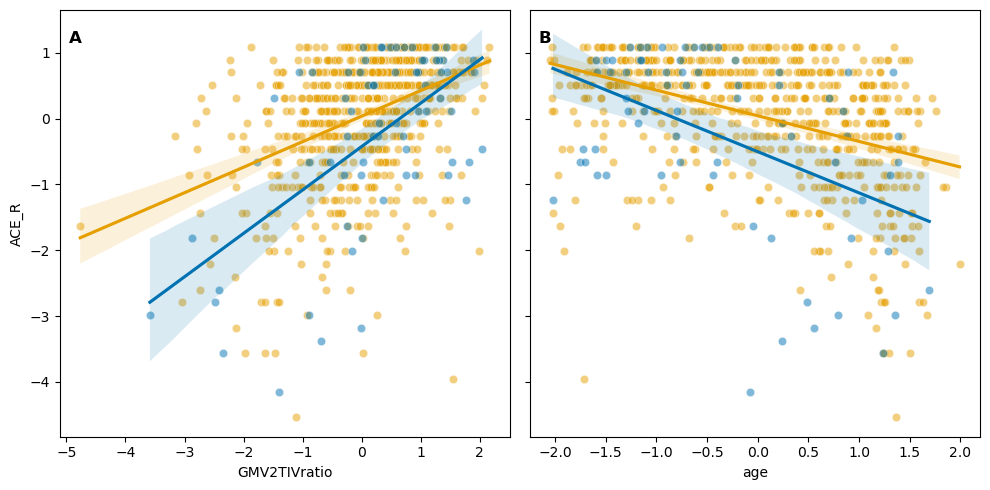

In [406]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load dataset
file_path = r'C:\Users\LAB-Mobile\Documents\Daniel\Research\CamCAN_data\Final_Merged_CAMCAN_aseg_lh_volume.csv'
df = pd.read_csv(file_path)

# Preprocess column names
df.columns = df.columns.str.replace(" ", "_")

# Handle missing values
required_columns = ["HD7", "HD3", "GMV2TIVratio", "ACE_R", "age", "sex", "Education"]
df = df.dropna(subset=required_columns)

# Compute the difference (Anhedonia-Dysphoria Difference)
df["Anhedonia-Dysphoria_Difference"] = df["HD7"] - df["HD3"]

# Standardize numerical variables
scaler = StandardScaler()
df[['ACE_R', 'GMV2TIVratio', 'Anhedonia-Dysphoria_Difference', 'age']] = scaler.fit_transform(
    df[['ACE_R', 'GMV2TIVratio', 'Anhedonia-Dysphoria_Difference', 'age']]
)

# Define colors
colors = {'Below Median ADD': '#E69F00', 'Above Median ADD': '#0072B2'}

# Define function for scatter plots with trendlines and confidence intervals
def scatter_with_trend(ax, x_var, y_var):
    median_val = df[y_var].median()
    below_median = df[df[y_var] <= median_val]
    above_median = df[df[y_var] > median_val]
    
    sns.scatterplot(x=below_median[x_var], y=below_median["ACE_R"], color=colors['Below Median ADD'], alpha=0.5, ax=ax)
    sns.scatterplot(x=above_median[x_var], y=above_median["ACE_R"], color=colors['Above Median ADD'], alpha=0.5, ax=ax)
    
    # Fit regression models with same line style and confidence intervals
    sns.regplot(x=below_median[x_var], y=below_median["ACE_R"], scatter=False, color=colors['Below Median ADD'], ci=95, ax=ax)
    sns.regplot(x=above_median[x_var], y=above_median["ACE_R"], scatter=False, color=colors['Above Median ADD'], ci=95, ax=ax)
    
    # Add panel label
    ax.text(0.02, 0.95, panel_labels.pop(0), transform=ax.transAxes, fontsize=12, fontweight='bold', va='top')
    
# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
panel_labels = ['A', 'B']

# Plot each interaction
scatter_with_trend(axes[0], "GMV2TIVratio", "Anhedonia-Dysphoria_Difference")
scatter_with_trend(axes[1], "age", "Anhedonia-Dysphoria_Difference")

# Adjust layout
plt.tight_layout()
plt.show()


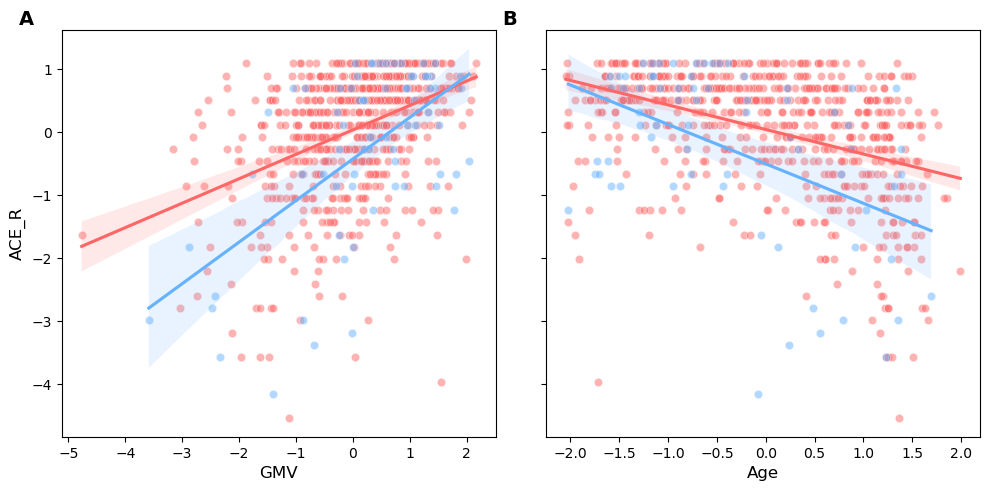

In [419]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load dataset
file_path = r'C:\Users\LAB-Mobile\Documents\Daniel\Research\CamCAN_data\Final_Merged_CAMCAN_aseg_lh_volume.csv'
df = pd.read_csv(file_path)

# Preprocess column names
df.columns = df.columns.str.replace(" ", "_")

# Handle missing values
required_columns = ["HD7", "HD3", "GMV2TIVratio", "ACE_R", "age", "sex", "Education"]
df = df.dropna(subset=required_columns)

# Compute the difference (Anhedonia-Dysphoria Difference)
df["Anhedonia-Dysphoria_Difference"] = df["HD7"] - df["HD3"]

# Standardize numerical variables
scaler = StandardScaler()
df[['ACE_R', 'GMV2TIVratio', 'Anhedonia-Dysphoria_Difference', 'age']] = scaler.fit_transform(
    df[['ACE_R', 'GMV2TIVratio', 'Anhedonia-Dysphoria_Difference', 'age']]
)

# Define updated colors
colors = {'Below Median ADD': '#FF6666', 'Above Median ADD': '#66B2FF'}

# Define function for scatter plots with trendlines and confidence intervals
def scatter_with_trend(ax, x_var, y_var, label, xlabel, ylabel):
    median_val = df[y_var].median()
    below_median = df[df[y_var] <= median_val]
    above_median = df[df[y_var] > median_val]
    
    sns.scatterplot(x=below_median[x_var], y=below_median["ACE_R"], color=colors['Below Median ADD'], alpha=0.5, ax=ax)
    sns.scatterplot(x=above_median[x_var], y=above_median["ACE_R"], color=colors['Above Median ADD'], alpha=0.5, ax=ax)
    
    # Fit regression models with same line style and confidence intervals
    sns.regplot(x=below_median[x_var], y=below_median["ACE_R"], scatter=False, color=colors['Below Median ADD'], ci=95, ax=ax)
    sns.regplot(x=above_median[x_var], y=above_median["ACE_R"], scatter=False, color=colors['Above Median ADD'], ci=95, ax=ax)
    
    # Add panel label in the top-left corner
    ax.text(-0.1, 1.05, label, transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

    # Set axis labels explicitly
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Plot each interaction with updated labels
scatter_with_trend(axes[0], "GMV2TIVratio", "Anhedonia-Dysphoria_Difference", "A", "GMV", "ACE_R")
scatter_with_trend(axes[1], "age", "Anhedonia-Dysphoria_Difference", "B", "Age", "ACE_R")

# Adjust layout
plt.tight_layout()
plt.show()


In [402]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load dataset
file_path = r'C:\Users\LAB-Mobile\Documents\Daniel\Research\CamCAN_data\Final_Merged_CAMCAN_aseg_lh_volume.csv'
df = pd.read_csv(file_path)

# Preprocess column names
df.columns = df.columns.str.replace(" ", "_")

# Handle missing values
required_columns = ["HD7", "HD3", "GMV2TIVratio", "ACE_R", "age", "sex", "Education"]
df = df.dropna(subset=required_columns)

# Filter to include only patients where HD7 + HD3 >= 1
df = df[df["HD7"] + df["HD3"] >= 1]

# Compute the ratio (HD7 + 1) / (HD3 + 1)
df["HD_ratio"] = (df["HD7"] + 1) / (df["HD3"] + 1)

# Standardize numerical variables
scaler = StandardScaler()
df[['ACE_R', 'GMV2TIVratio', 'HD_ratio', 'age']] = scaler.fit_transform(
    df[['ACE_R', 'GMV2TIVratio', 'HD_ratio', 'age']]
)

# Encode sex as a binary variable (assuming 0 = male, 1 = female)
df['sex'] = df['sex'].astype(int)

# GLM model with all two-way and three-way interaction terms
def glm_model(iv):
    X = sm.add_constant(df[[iv, "age", "GMV2TIVratio"]])
    X[f"{iv}_x_GMV2TIVratio"] = df[iv] * df["GMV2TIVratio"]  # Two-way interaction
    X[f"{iv}_x_age"] = df[iv] * df["age"]  # Two-way interaction
    X["GMV2TIVratio_x_age"] = df["GMV2TIVratio"] * df["age"]  # Two-way interaction
    X[f"{iv}_x_GMV2TIVratio_x_age"] = df[iv] * df["GMV2TIVratio"] * df["age"]  # Three-way interaction
    
    # Add sex and education as covariates but without interactions
    X["sex"] = df["sex"]
    X["Education"] = df["Education"]
    
    model = sm.OLS(df["ACE_R"], X).fit()
    
    print(f"GLM Analysis for {iv} → ACE_R (Including GMV2TIVratio, Sex, Education & All Interactions)")
    print(model.summary())
    
    return model

# Run GLM model
model_hd_ratio = glm_model("HD_ratio")


GLM Analysis for HD_ratio → ACE_R (Including GMV2TIVratio, Sex, Education & All Interactions)
                            OLS Regression Results                            
Dep. Variable:                  ACE_R   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     16.64
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           9.48e-21
Time:                        08:57:48   Log-Likelihood:                -265.28
No. Observations:                 229   AIC:                             550.6
Df Residuals:                     219   BIC:                             584.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------

In [370]:
df['HD_diff'] = df['HD7'] - df['HD3']
df['HD_log_ratio'] = np.log(df['HD7'] + 1) - np.log(df['HD3'] + 1)

# בדיקת מתאם עם ACE_R
df[['HD_ratio', 'HD_diff', 'HD_log_ratio', 'ACE_R']].corr()


,HD_ratio,HD_diff,HD_log_ratio,ACE_R
HD_ratio,1.000000,0.937729,0.923819,-0.074190
HD_diff,0.937729,1.000000,0.980255,-0.037524
HD_log_ratio,0.923819,0.980255,1.000000,-0.040563
ACE_R,-0.074190,-0.037524,-0.040563,1.000000


In [372]:
# Create separate groups
df["NDG"] = (df["HD7"] == 0) & (df["HD3"] == 0)  # No Depression Group
df["EADG"] = (df["HD7"] == df["HD3"]) & (df["HD7"] > 0)  # Equal Anhedonia-Dysphoria Group

# Count participants
num_NDG = df["NDG"].sum()
num_EADG = df["EADG"].sum()
print(f"NDG (No Depression): {num_NDG}, EADG (Equal A-D): {num_EADG}")

# Compare ACE_R scores between the two groups
ndg_scores = df[df["NDG"]]["ACE_R"]
eadg_scores = df[df["EADG"]]["ACE_R"]

# Check descriptive stats
print("\nACE_R Distribution:")
print("No Depression Group (NDG):", ndg_scores.describe())
print("Equal A-D Group (EADG):", eadg_scores.describe())

# Statistical test (T-test and Mann-Whitney U test)
from scipy.stats import ttest_ind, mannwhitneyu

t_stat, p_value = ttest_ind(ndg_scores, eadg_scores, nan_policy='omit')
u_stat, p_mwu = mannwhitneyu(ndg_scores, eadg_scores, nan_policy='omit')

print(f"\nT-test: t={t_stat:.3f}, p={p_value:.3f}")
print(f"Mann-Whitney U: U={u_stat:.3f}, p={p_mwu:.3f}")


NDG (No Depression): 504, EADG (Equal A-D): 18

ACE_R Distribution:
No Depression Group (NDG): count    504.000000
mean       0.037064
std        0.963314
min       -4.538073
25%       -0.461355
50%        0.315162
75%        0.703421
max        1.091680
Name: ACE_R, dtype: float64
Equal A-D Group (EADG): count    18.000000
mean      0.282807
std       0.762837
min      -1.626132
25%      -0.024564
50%       0.509292
75%       0.703421
max       1.091680
Name: ACE_R, dtype: float64

T-test: t=-1.070, p=0.285
Mann-Whitney U: U=3880.000, p=0.295


In [412]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load dataset
file_path = r'C:\Users\LAB-Mobile\Documents\Daniel\Research\CamCAN_data\Final_Merged_CAMCAN_aseg_lh_volume.csv'
df = pd.read_csv(file_path)

# Preprocess column names
df.columns = df.columns.str.replace(" ", "_")

# Handle missing values
required_columns = ["HD7", "HD3", "GMV2TIVratio", "ACE_R", "age", "sex", "Education"]
df = df.dropna(subset=required_columns)

# Compute the ratio (HD7 + 1) / (HD3 + 1)
df["HD_ratio"] = (df["HD7"]) - (df["HD3"])

# Standardize numerical variables
scaler = StandardScaler()
df[['ACE_R', 'GMV2TIVratio', 'HD_ratio', 'age']] = scaler.fit_transform(
    df[['ACE_R', 'GMV2TIVratio', 'HD_ratio', 'age']]
)

# Encode sex as a binary variable (assuming 0 = male, 1 = female)
df['sex'] = df['sex'].astype(int)

# GLM model with all two-way and three-way interaction terms
def glm_model(iv):
    X = sm.add_constant(df[[iv, "age", "GMV2TIVratio"]])
    X[f"{iv}_x_GMV2TIVratio"] = df[iv] * df["GMV2TIVratio"]  # Two-way interaction
    X[f"{iv}_x_age"] = df[iv] * df["age"]  # Two-way interaction
    X["GMV2TIVratio_x_age"] = df["GMV2TIVratio"] * df["age"]  # Two-way interaction
    X[f"{iv}_x_GMV2TIVratio_x_age"] = df[iv] * df["GMV2TIVratio"] * df["age"]  # Three-way interaction
    
    # Add sex and education as covariates but without interactions
    X["sex"] = df["sex"]
    X["Education"] = df["Education"]
    
    model = sm.OLS(df["ACE_R"], X).fit()
    
    print(f"\nGLM Analysis for {iv} → ACE_R (Including GMV2TIVratio, Sex, Education & All Interactions)")
    
    # Extract model coefficients and p-values with full precision
    results_df = pd.DataFrame({
        "Coefficient": model.params,
        "Std Error": model.bse,
        "t-value": model.tvalues,
        "p-value": model.pvalues
    })
    
    # Display results with full precision
    pd.set_option('display.float_format', lambda x: f'{x:.20f}')
    print(results_df)
    
    return model

# Run GLM model
model_hd_ratio = glm_model("HD_ratio")



GLM Analysis for HD_ratio → ACE_R (Including GMV2TIVratio, Sex, Education & All Interactions)
                                          Coefficient              Std Error  \
const                         -0.61868186167314620505 0.10061957268664596665   
HD_ratio                      -0.04525918486343482455 0.04091137262509006445   
age                           -0.24961210980159725947 0.05510118477046125479   
GMV2TIVratio                   0.12735048182628344593 0.05579018274146807510   
HD_ratio_x_GMV2TIVratio        0.13285399702117092757 0.05588054809343583063   
HD_ratio_x_age                 0.11980641790893668819 0.05683729412160600653   
GMV2TIVratio_x_age             0.18582345090030749635 0.03272788871012757145   
HD_ratio_x_GMV2TIVratio_x_age -0.00689153459619330083 0.02778149582696221032   
sex                           -0.03000548674037437080 0.06507022409287650799   
Education                      0.30619595915591268920 0.03338859166161305819   

                        